# Business Case 4

## Data import and Preprocessing

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Fintech/Business Case 4/

Mounted at /gdrive
/gdrive/My Drive/Fintech/Business Case 4


In [2]:
!ls

BusinessCase4.ipynb  InvestmentReplica.xlsx


In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

In [4]:
file_path = 'InvestmentReplica.xlsx'
df = pd.read_excel(file_path, sheet_name='Replica')
print(df.head())

        Date     MXWO    MXWD  LEGATRUU   HFRXGL     RX1         TY1    GC1  \
0 2007-10-23  1633.44  414.14  350.2138  1343.63  113.70  110.515625  759.0   
1 2007-10-30  1663.89  423.26  352.5413  1356.53  113.79  110.656250  787.8   
2 2007-11-06  1651.59  419.51  354.1758  1360.20  113.79  110.875000  823.4   
3 2007-11-13  1601.81  405.98  357.2217  1347.16  114.35  111.718750  799.0   
4 2007-11-20  1570.74  398.54  359.4446  1335.21  114.72  113.156250  791.4   

     CO1      ES1     VG1      NQ1    LLL1     TP1      DU1         TU2  
0  82.85  1525.50  4393.0  2212.00  1287.0  1570.5  103.385  103.718750  
1  87.44  1536.00  4476.0  2217.75  1323.9  1610.5  103.410  103.812500  
2  93.26  1525.00  4425.0  2233.50  1320.0  1575.5  103.410  104.046875  
3  88.83  1483.25  4323.0  2066.75  1271.0  1440.5  103.595  104.304688  
4  95.49  1446.00  4296.0  2035.50  1225.2  1472.5  103.800  104.945312  


## Data Exploration

We choose to replicate HFRX index using Futures contracts.

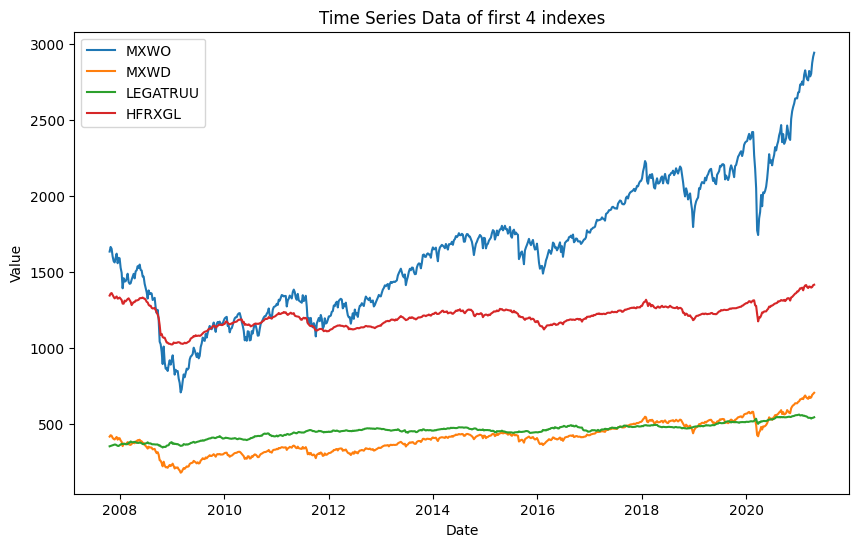

In [5]:
# Plotting
plt.figure(figsize=(10, 6))  # Adjust size if needed

# Plot each column
plt.plot(df['Date'], df['MXWO'], label='MXWO')
plt.plot(df['Date'], df['MXWD'], label='MXWD')
plt.plot(df['Date'], df['LEGATRUU'], label='LEGATRUU')
plt.plot(df['Date'], df['HFRXGL'], label='HFRXGL')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data of first 4 indexes')
plt.legend()  # Show legend with labels

plt.show()

Now we normalize each serie by dividing it by its first element.

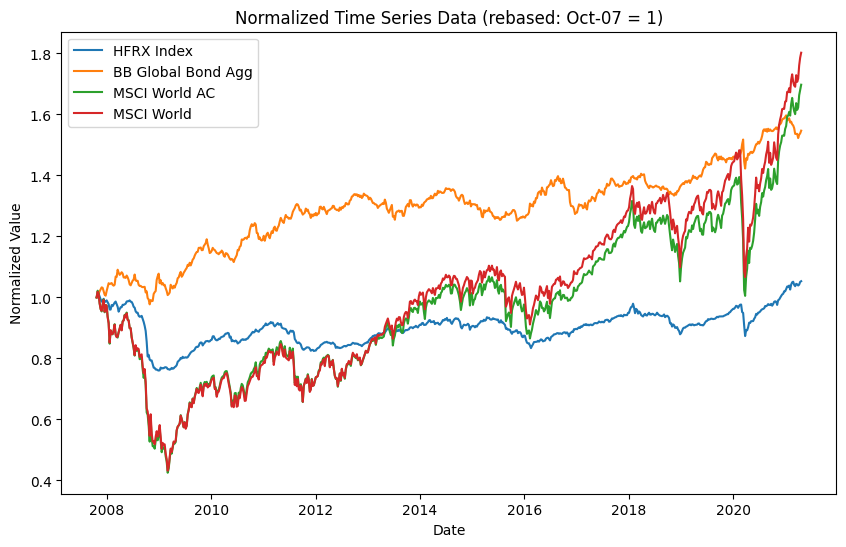

In [6]:
# Normalize data
df_normalized = df.copy()
for col in ['HFRXGL', 'LEGATRUU', 'MXWD', 'MXWO']:
    df_normalized[col] = df[col] / df[col].iloc[0]

# Plotting
plt.figure(figsize=(10, 6))  # Adjust size if needed

# Plot each column
plt.plot(df['Date'], df_normalized['HFRXGL'], label='HFRX Index')
plt.plot(df['Date'], df_normalized['LEGATRUU'], label='BB Global Bond Agg')
plt.plot(df['Date'], df_normalized['MXWD'], label='MSCI World AC')
plt.plot(df['Date'], df_normalized['MXWO'], label='MSCI World')

plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.title('Normalized Time Series Data (rebased: Oct-07 = 1)')
plt.legend()  # Show legend with labels

plt.show()

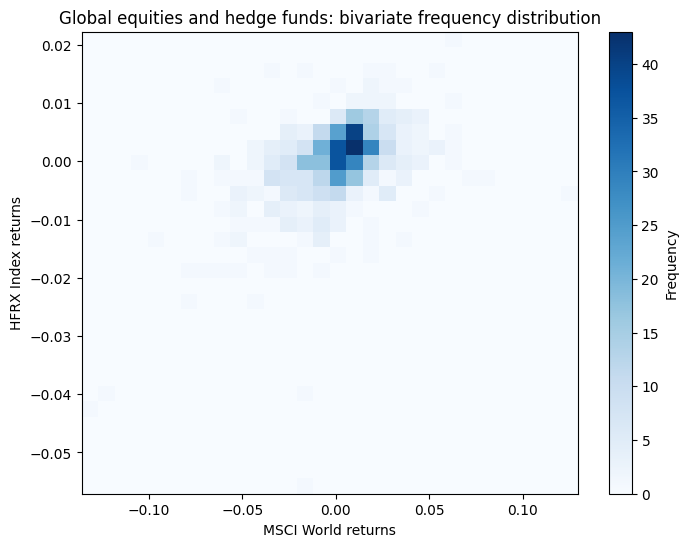

In [7]:
# Calculate returns for MSCI World and HFRX Index
returns_MXWO = df['MXWO'].pct_change().dropna()
returns_HFRXGL = df['HFRXGL'].pct_change().dropna()

# Plotting
plt.figure(figsize=(8, 6))  # Adjust size if needed

plt.hist2d(returns_MXWO, returns_HFRXGL, bins=30, cmap='Blues')

plt.xlabel('MSCI World returns')
plt.ylabel('HFRX Index returns')
plt.title('Global equities and hedge funds: bivariate frequency distribution')

plt.colorbar(label='Frequency')

plt.show()


next histogram doesn't feel right

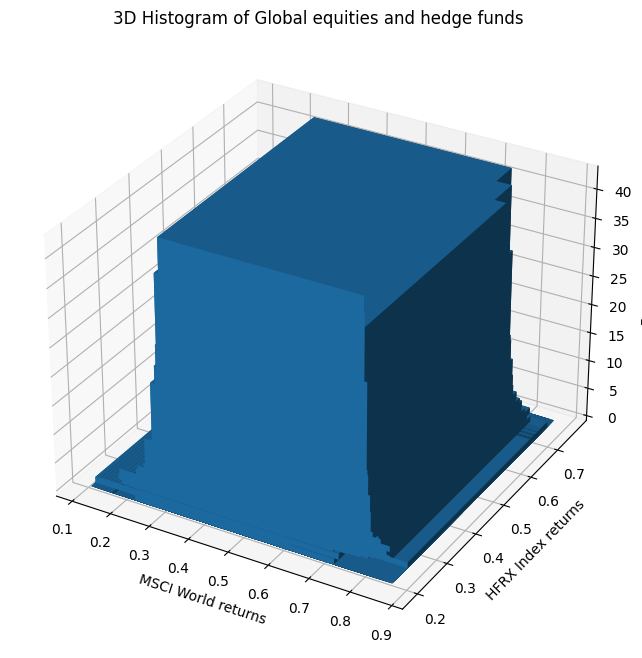

In [8]:
# Compute 2D histogram
hist, xedges, yedges = np.histogram2d(returns_MXWO, returns_HFRXGL, bins=30)

# Construct arrays for the bar plot
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', cmap='Blues')

ax.set_xlabel('MSCI World returns')
ax.set_ylabel('HFRX Index returns')
ax.set_zlabel('Frequency')
ax.set_title('3D Histogram of Global equities and hedge funds')

plt.show()


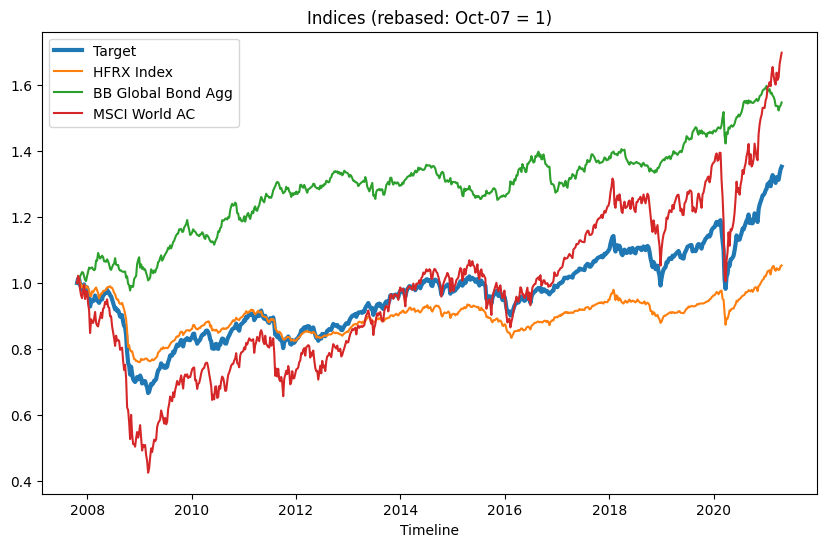

In [9]:
# target index
y = 0.5 * df['HFRXGL'] + 0.25 * df['MXWO'] + 0.25 * df['LEGATRUU']
target = y
df['Target'] = target

# Plotting
plt.figure(figsize=(10, 6))

# Plot Monster Index
plt.plot(df['Date'], target/target.iloc[0], label='Target', linewidth=3)

# Plot other indices
plt.plot(df['Date'], df['HFRXGL'] / df['HFRXGL'].iloc[0], label='HFRX Index')
plt.plot(df['Date'], df['LEGATRUU'] / df['LEGATRUU'].iloc[0], label='BB Global Bond Agg')
plt.plot(df['Date'], df['MXWD'] / df['MXWD'].iloc[0], label='MSCI World AC')

plt.xlabel('Timeline')
plt.title('Indices (rebased: Oct-07 = 1)')
plt.legend()

plt.show()

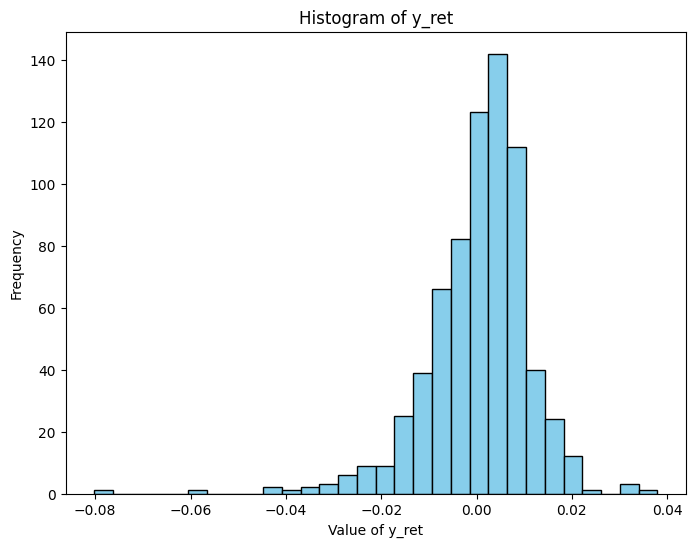

In [10]:
y_ret = y.pct_change().dropna()

plt.figure(figsize=(8, 6))
# Plot histogram
plt.hist(y_ret, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Value of y_ret')
plt.ylabel('Frequency')
plt.title('Histogram of y_ret')
plt.show()

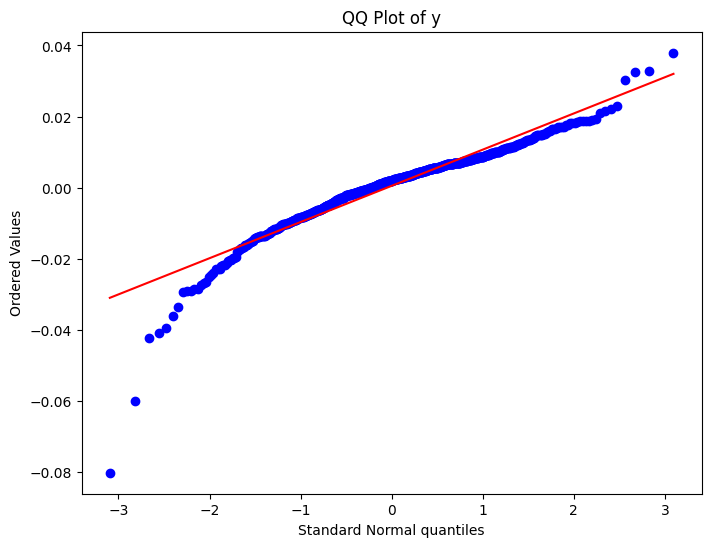

In [11]:
import scipy.stats as stats

plt.figure(figsize=(8, 6))
# Create QQ plot
stats.probplot(y_ret, dist="norm", plot=plt)
plt.xlabel('Standard Normal quantiles')
plt.ylabel('Ordered Values')
plt.title('QQ Plot of y')
plt.show()

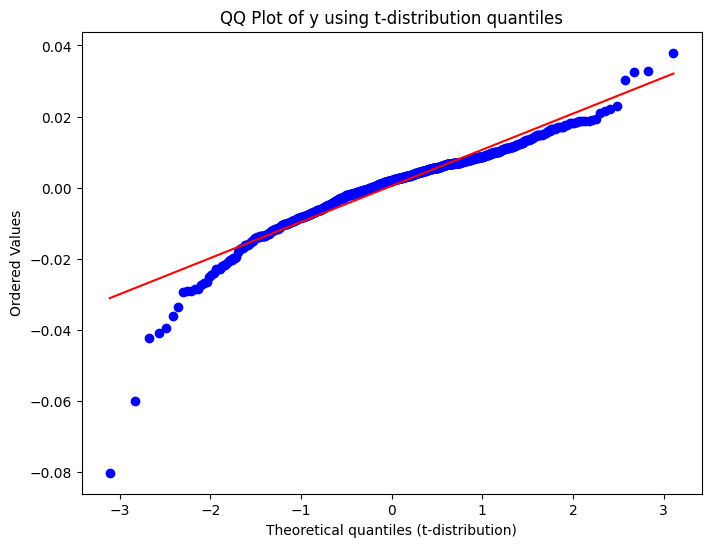

In [12]:
plt.figure(figsize=(8, 6))
# Calculate t-distribution quantiles
t_dist = stats.t(df=len(y_ret) - 1)
t_quantiles = t_dist.ppf(stats.uniform.rvs(size=len(y_ret)))
# Create QQ plot
stats.probplot(y_ret, dist=t_dist, plot=plt)

plt.xlabel('Theoretical quantiles (t-distribution)')
plt.ylabel('Ordered Values')
plt.title('QQ Plot of y using t-distribution quantiles')
plt.show()

now we plot the futures

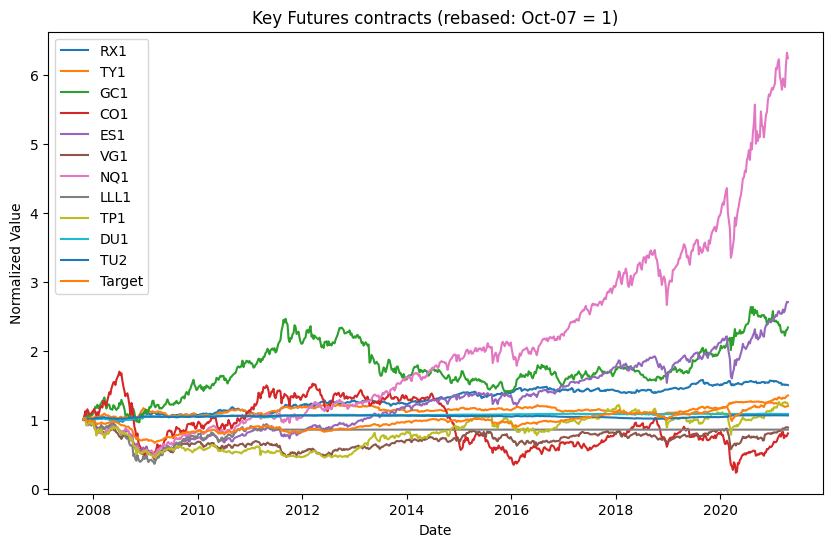

In [13]:
# Normalize data
df_normalized = df.copy()
for col in df.columns[1:]:
    df_normalized[col] = df[col] / df[col].iloc[0]

# Plotting
plt.figure(figsize=(10, 6))  # Adjust size if needed

# Plot each column

for col in df.columns[5:]:
  plt.plot(df['Date'], df_normalized[col], label=col)

plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.title('Key Futures contracts (rebased: Oct-07 = 1)')
plt.legend()  # Show legend with labels

plt.show()


And we explore the correlation among them

In [14]:
df.columns

Index(['Date', 'MXWO', 'MXWD', 'LEGATRUU', 'HFRXGL', 'RX1', 'TY1', 'GC1',
       'CO1', 'ES1', 'VG1', 'NQ1', 'LLL1', 'TP1', 'DU1', 'TU2', 'Target'],
      dtype='object')

In [15]:
import seaborn as sns

Pearson correlation

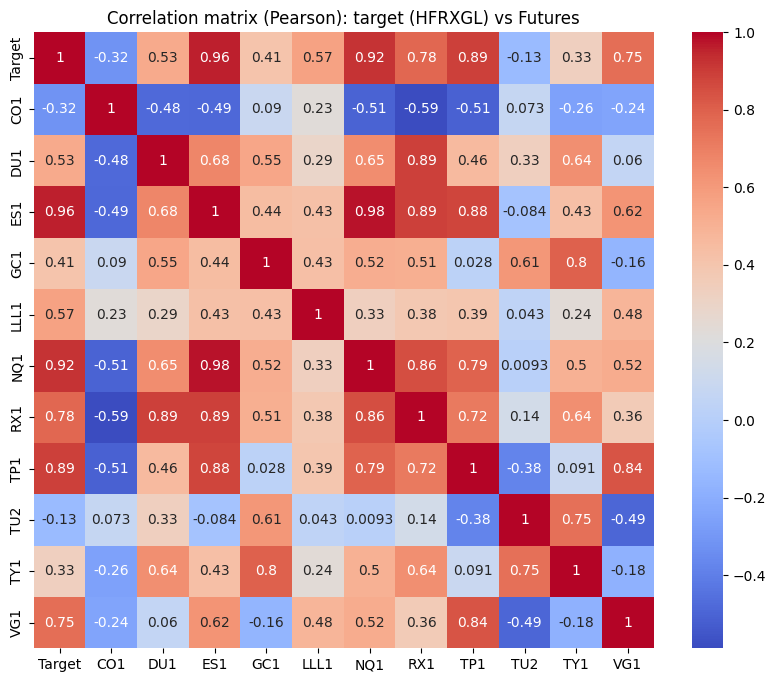

In [16]:
# Define the variables
yvalues = ['Target', 'CO1', 'DU1', 'ES1', 'GC1', 'LLL1', 'NQ1', 'RX1', 'TP1', 'TU2', 'TY1', 'VG1']
xvalues = yvalues#df.columns[5:].tolist()  # Get all column names in the DataFrame starting from the 5th column

# Compute the correlation between each column in 'df' and each variable in 'yvalues'
correlation_values = [[df[col].corr(df[y]) for col in xvalues] for y in yvalues]

# Create a DataFrame from the correlation values
correlation_df = pd.DataFrame(correlation_values, index=yvalues, columns=xvalues)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm')
plt.title('Correlation matrix (Pearson): target (HFRXGL) vs Futures')
plt.show()


Kendall correlation

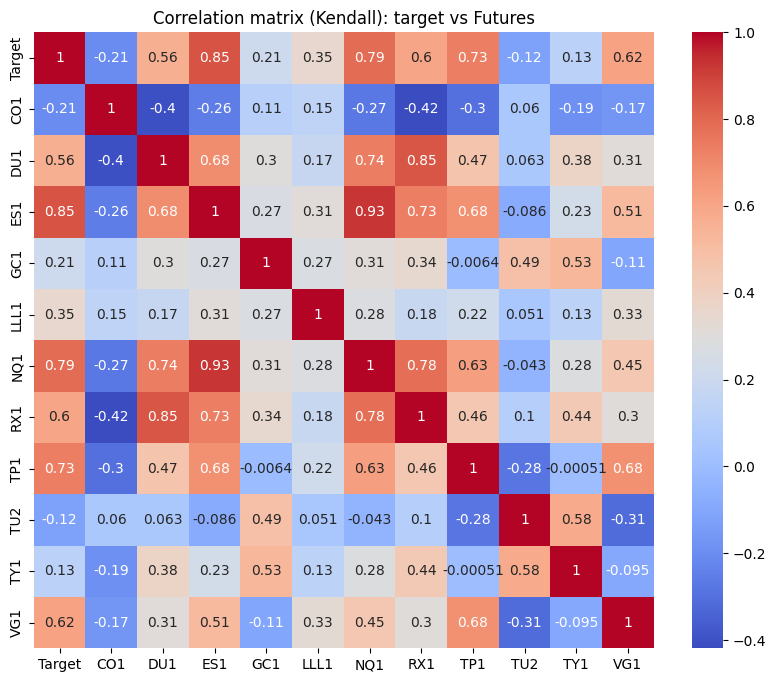

In [17]:
# Compute the Kendall correlation between each column in 'df' and each variable in 'yvalues'
correlation_values = [[df[col].corr(df[y], method='kendall') for col in xvalues] for y in yvalues]

# Create a DataFrame from the correlation values
correlation_df = pd.DataFrame(correlation_values, index=yvalues, columns=xvalues)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm')
plt.title('Correlation matrix (Kendall): target vs Futures')
plt.show()

Target returns autocorrelation and partial autocorrelation

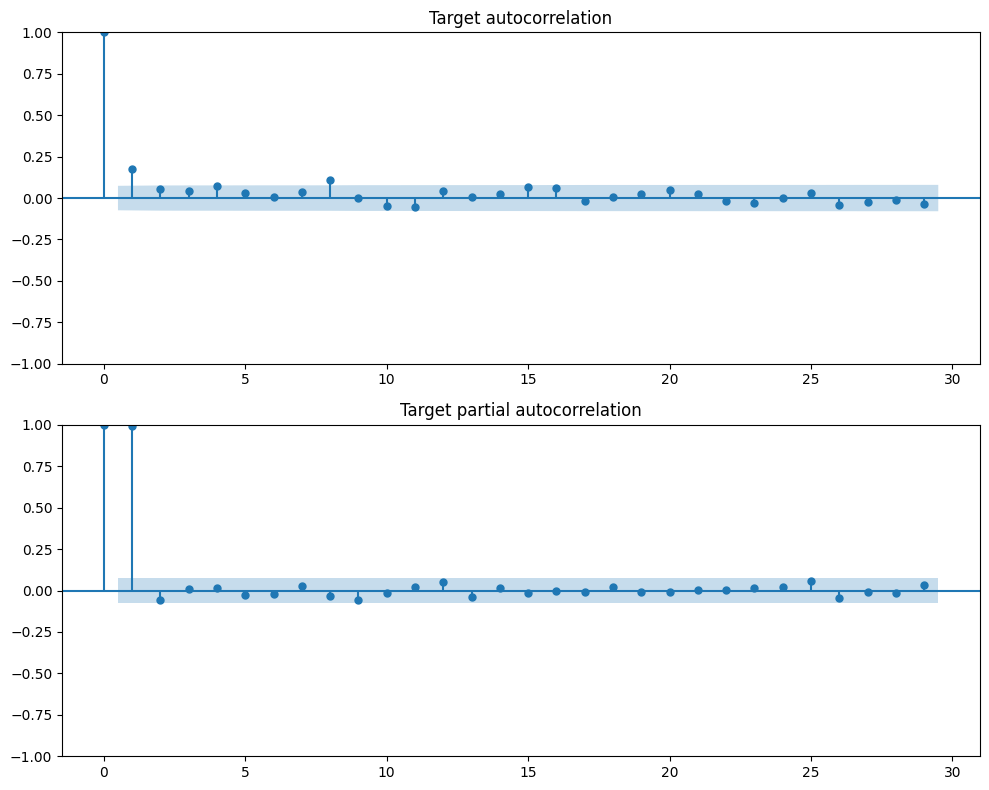

In [18]:
import statsmodels.api as sm

# Assuming y is your variable of interest

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Autocorrelation plot
sm.graphics.tsa.plot_acf(y_ret, ax=axes[0])
axes[0].set_title('Target autocorrelation')

# Partial autocorrelation plot
sm.graphics.tsa.plot_pacf(y, ax=axes[1])
axes[1].set_title('Target partial autocorrelation')

plt.tight_layout()
plt.show()


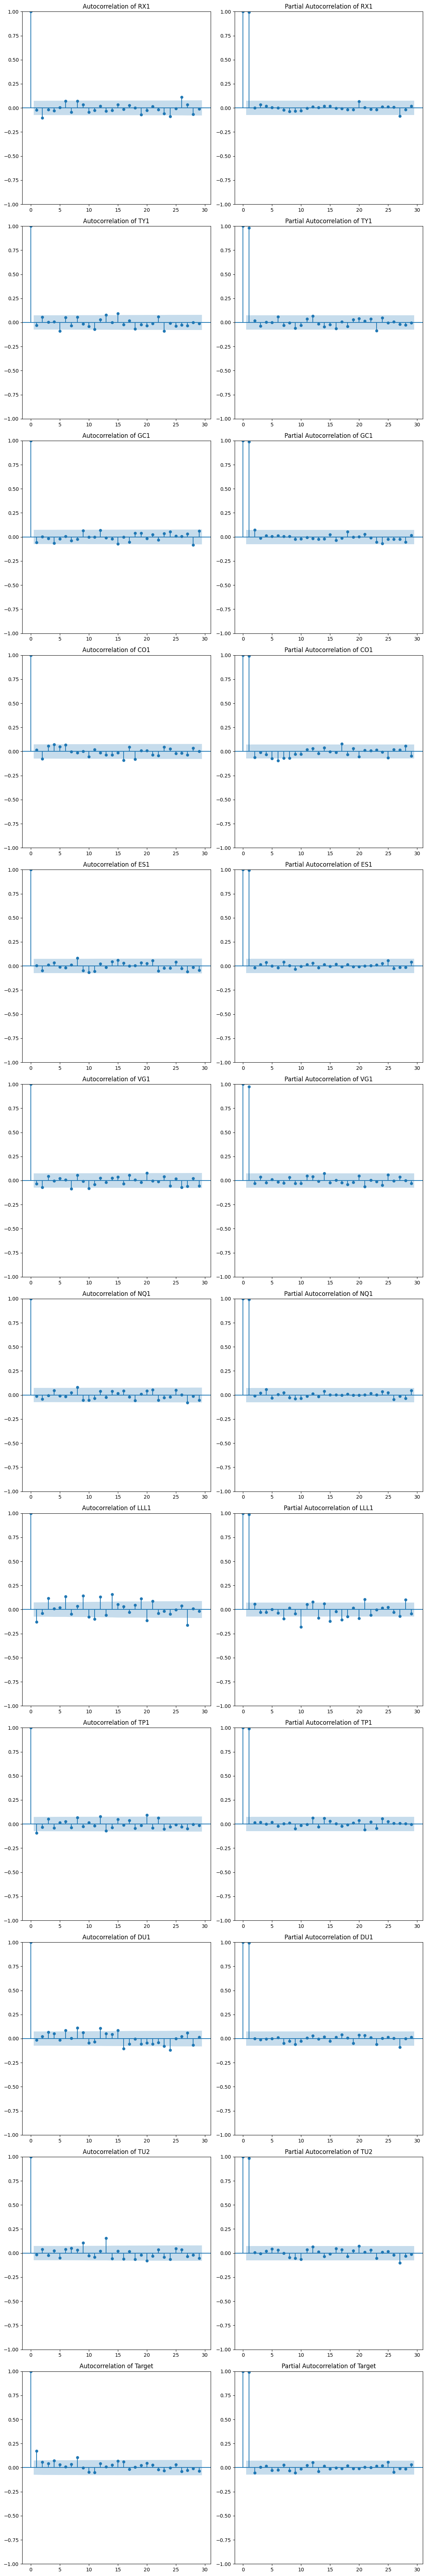

In [19]:
# Get column names starting from the 5th column
columns_to_plot = df.columns[5:]

# Create subplots
fig, axes = plt.subplots(len(columns_to_plot), 2, figsize=(12, 6*len(columns_to_plot)))

# Loop through each column
for i, col in enumerate(columns_to_plot):
    # Autocorrelation plot
    sm.graphics.tsa.plot_acf(df[col].pct_change().dropna(), ax=axes[i, 0])
    axes[i, 0].set_title(f'Autocorrelation of {col}')

    # Partial autocorrelation plot
    sm.graphics.tsa.plot_pacf(df[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Partial Autocorrelation of {col}')

plt.tight_layout()
plt.show()


## Regressions

In [20]:
df.columns[5:-1]

Index(['RX1', 'TY1', 'GC1', 'CO1', 'ES1', 'VG1', 'NQ1', 'LLL1', 'TP1', 'DU1',
       'TU2'],
      dtype='object')

In [37]:
# Create a new DataFrame X with columns from df.columns[5:]
X = df[df.columns[5:-1]].copy()
X_ret = df[df.columns[5:-1]].copy()

# Apply pct_change and dropna to each column
for col in X_ret.columns:
    X_ret[col] = X_ret[col].pct_change().dropna()

X = X.dropna()
X_ret = X_ret.dropna()

y = df['Target']
y_ret = y.pct_change().dropna()

# Display the resulting DataFrame
print(X.head())
print(y)

print(X_ret.head())
print(y_ret)

      RX1         TY1    GC1    CO1      ES1     VG1      NQ1    LLL1     TP1  \
0  113.70  110.515625  759.0  82.85  1525.50  4393.0  2212.00  1287.0  1570.5   
1  113.79  110.656250  787.8  87.44  1536.00  4476.0  2217.75  1323.9  1610.5   
2  113.79  110.875000  823.4  93.26  1525.00  4425.0  2233.50  1320.0  1575.5   
3  114.35  111.718750  799.0  88.83  1483.25  4323.0  2066.75  1271.0  1440.5   
4  114.72  113.156250  791.4  95.49  1446.00  4296.0  2035.50  1225.2  1472.5   

       DU1         TU2  
0  103.385  103.718750  
1  103.410  103.812500  
2  103.410  104.046875  
3  103.595  104.304688  
4  103.800  104.945312  
0      1167.728450
1      1182.372825
2      1181.541450
3      1163.337925
4      1150.151150
          ...     
700    1532.216650
701    1532.628675
702    1553.349750
703    1570.272175
704    1578.996950
Name: Target, Length: 705, dtype: float64
        RX1       TY1       GC1       CO1       ES1       VG1       NQ1  \
1  0.000792  0.001272  0.037945  0.05

### Least Squares Regression (on returns)

In [22]:
X_ME = X_ret[:350]
y_ME = y_ret[:350]

In [23]:
# Fit OLS model
#X_with_const = sm.add_constant(X_ME)  # Add constant term
model = sm.OLS(y_ME, X_ME)
results = model.fit()

# Print summary of the model
print(results.summary())


                                 OLS Regression Results                                
Dep. Variable:                 Target   R-squared (uncentered):                   0.836
Model:                            OLS   Adj. R-squared (uncentered):              0.831
Method:                 Least Squares   F-statistic:                              157.6
Date:                Fri, 26 Apr 2024   Prob (F-statistic):                   4.99e-126
Time:                        08:41:25   Log-Likelihood:                          1403.9
No. Observations:                 350   AIC:                                     -2786.
Df Residuals:                     339   BIC:                                     -2743.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

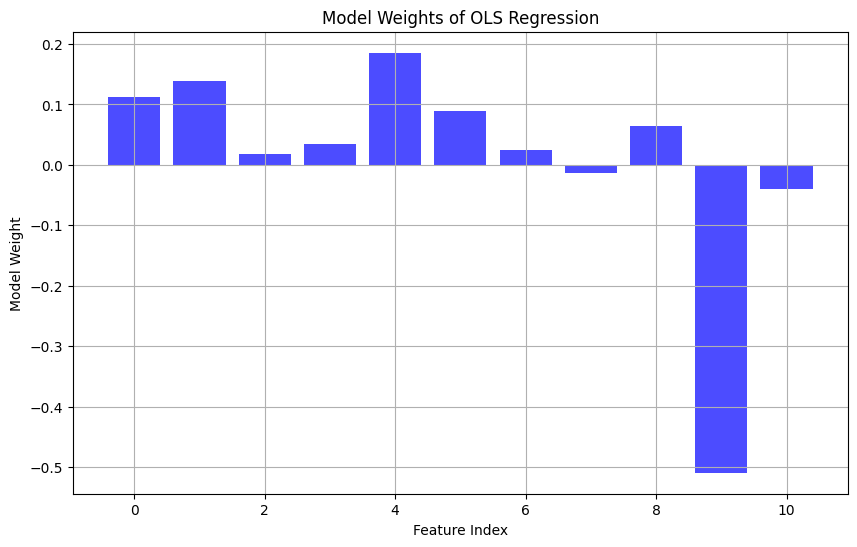

In [25]:
# Get the best estimator from grid search
parameters = results.params

# Plot the model weights
plt.figure(figsize=(10, 6))
plt.bar(range(len(parameters)), parameters, color='blue', alpha=0.7)
plt.xlabel('Feature Index')
plt.ylabel('Model Weight')
plt.title('Model Weights of OLS Regression')
plt.grid(True)
plt.show()

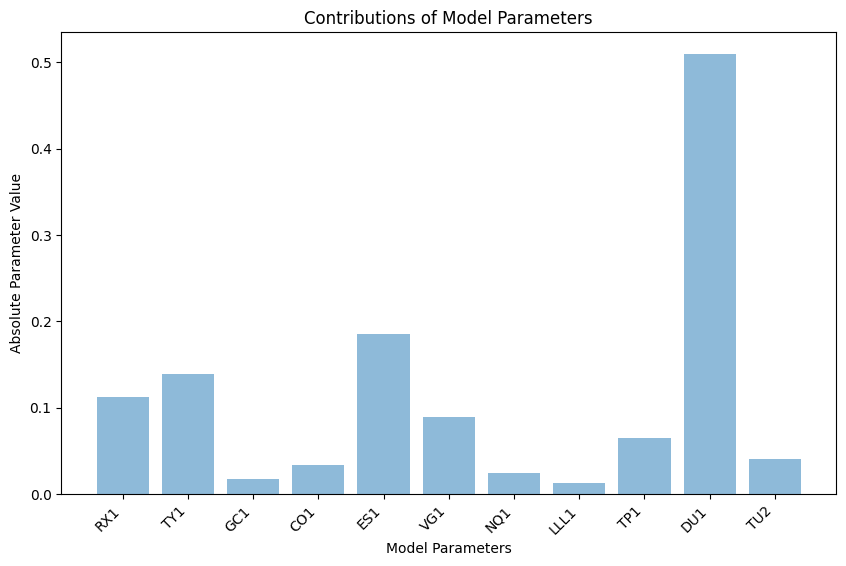

In [ ]:
# Get model parameters
parameters = results.params

# Plot contributions
plt.figure(figsize=(10, 6))
plt.bar(parameters.index, abs(parameters), alpha=0.5)

plt.xlabel('Model Parameters')
plt.ylabel('Absolute Parameter Value')
plt.title('Contributions of Model Parameters')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()


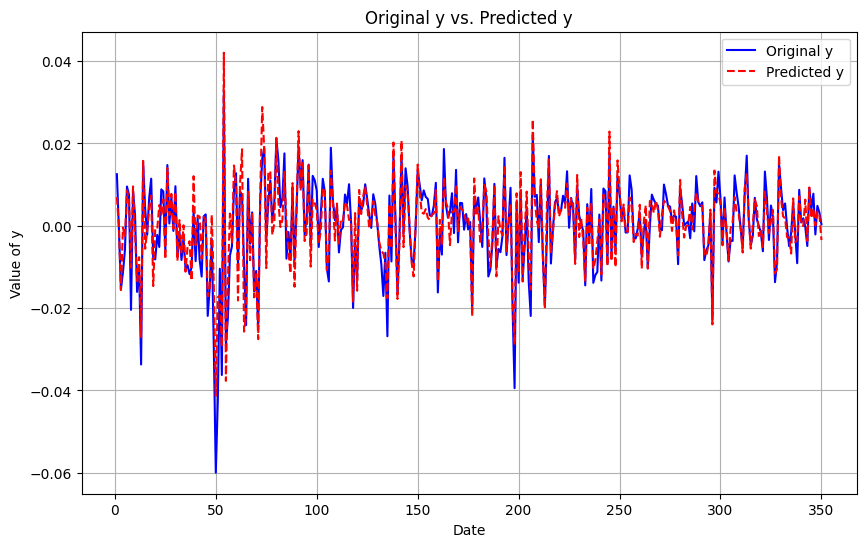

In [26]:
# Get the predicted y values
predicted_y = results.predict(X_ME)

# Plot original y and predicted y
plt.figure(figsize=(10, 6))
plt.plot(y_ME.index, y_ME, label='Original y', color='blue')
plt.plot(y_ME.index, predicted_y, label='Predicted y', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value of y')
plt.title('Original y vs. Predicted y')
plt.legend()
plt.grid(True)
plt.show()


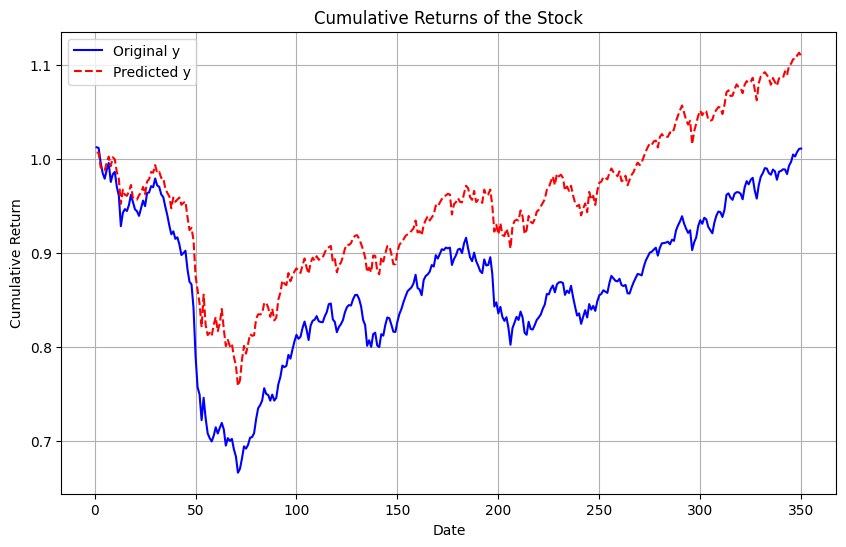

In [ ]:
# Calculate cumulative returns
cumulative_y_ME = (1 + y_ME).cumprod()
cumulative_predicted_y = (1 + predicted_y).cumprod()

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(y_ME.index, cumulative_y_ME, label='Original y', color='blue')
plt.plot(y_ME.index, cumulative_predicted_y, label='Predicted y', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns of the Stock')
plt.legend()
plt.grid(True)
plt.show()


Good, our predicted y is above the real one.

### Least Squares Regression on positive returns

In [27]:
X_ME = X_ret[:350]
y_ME = y_ret[:350]

In [28]:
y_ME[y_ME < 0] = 0
y_ME

1      0.012541
2      0.000000
3      0.000000
4      0.000000
5      0.000000
         ...   
346    0.007795
347    0.000000
348    0.004856
349    0.003200
350    0.000364
Name: Target, Length: 350, dtype: float64

In [29]:
# Fit OLS model
#X_with_const = sm.add_constant(X_ME)  # Add constant term
model = sm.OLS(y_ME, X_ME)
results = model.fit()

# Print summary of the model
print(results.summary())


                                 OLS Regression Results                                
Dep. Variable:                 Target   R-squared (uncentered):                   0.421
Model:                            OLS   Adj. R-squared (uncentered):              0.402
Method:                 Least Squares   F-statistic:                              22.42
Date:                Fri, 26 Apr 2024   Prob (F-statistic):                    2.68e-34
Time:                        08:43:41   Log-Likelihood:                          1350.2
No. Observations:                 350   AIC:                                     -2678.
Df Residuals:                     339   BIC:                                     -2636.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

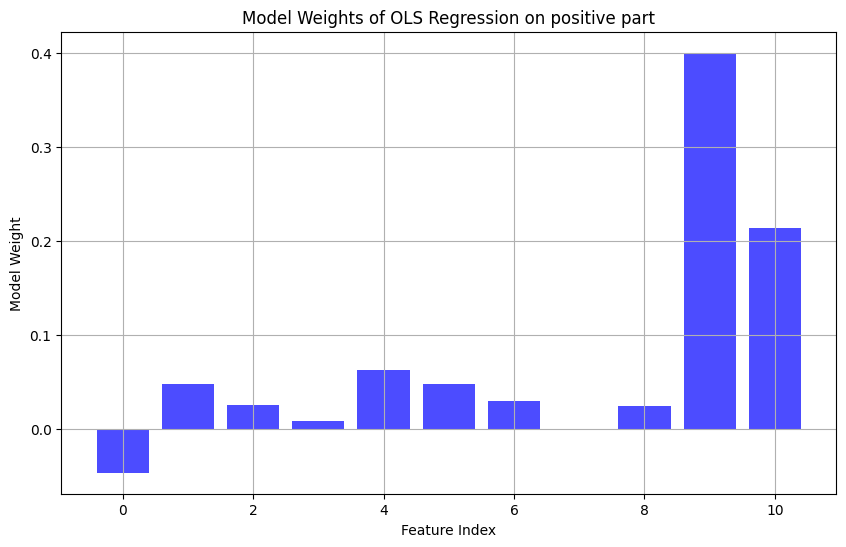

In [31]:
# Get the best estimator from grid search
parameters = results.params

# Plot the model weights
plt.figure(figsize=(10, 6))
plt.bar(range(len(parameters)), parameters, color='blue', alpha=0.7)
plt.xlabel('Feature Index')
plt.ylabel('Model Weight')
plt.title('Model Weights of OLS Regression on positive part')
plt.grid(True)
plt.show()

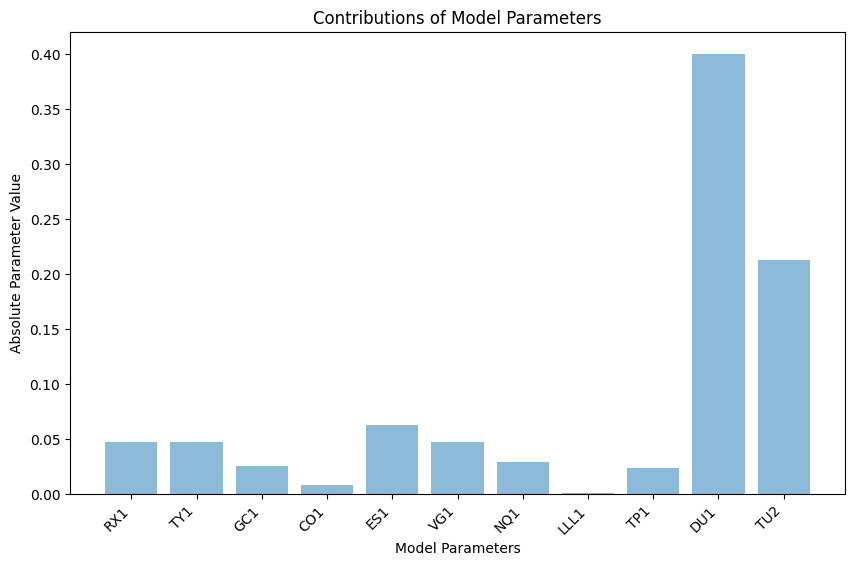

In [ ]:
# Get model parameters
parameters = results.params

# Plot contributions
plt.figure(figsize=(10, 6))
plt.bar(parameters.index, abs(parameters), alpha=0.5)

plt.xlabel('Model Parameters')
plt.ylabel('Absolute Parameter Value')
plt.title('Contributions of Model Parameters')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()


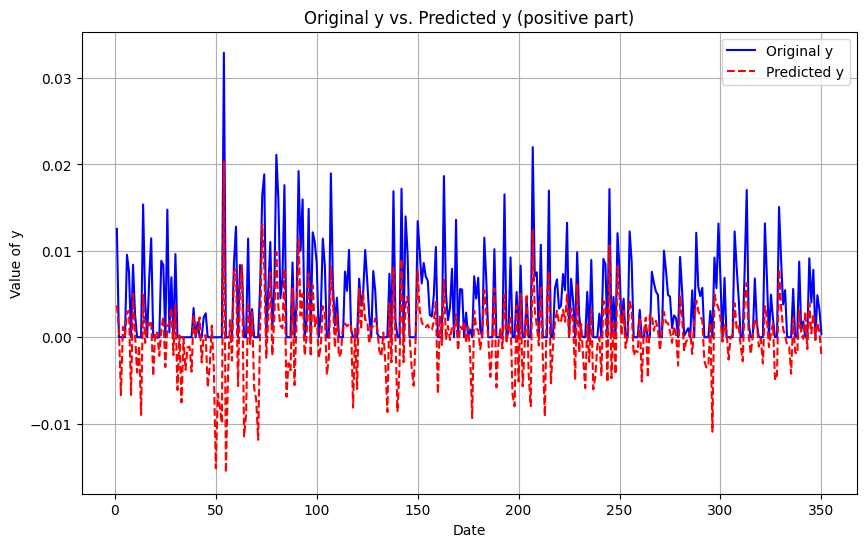

In [33]:
# Get the predicted y values
predicted_y = results.predict(X_ME)

# Plot original y and predicted y
plt.figure(figsize=(10, 6))
plt.plot(y_ME.index, y_ME, label='Original y', color='blue')
plt.plot(y_ME.index, predicted_y, label='Predicted y', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value of y')
plt.title('Original y vs. Predicted y (positive part)')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
y_ME = y_ret[:350]

In [39]:
y_ret

1      0.012541
2     -0.000703
3     -0.015407
4     -0.011335
5     -0.005836
         ...   
700   -0.006454
701    0.000269
702    0.013520
703    0.010894
704    0.005556
Name: Target, Length: 704, dtype: float64

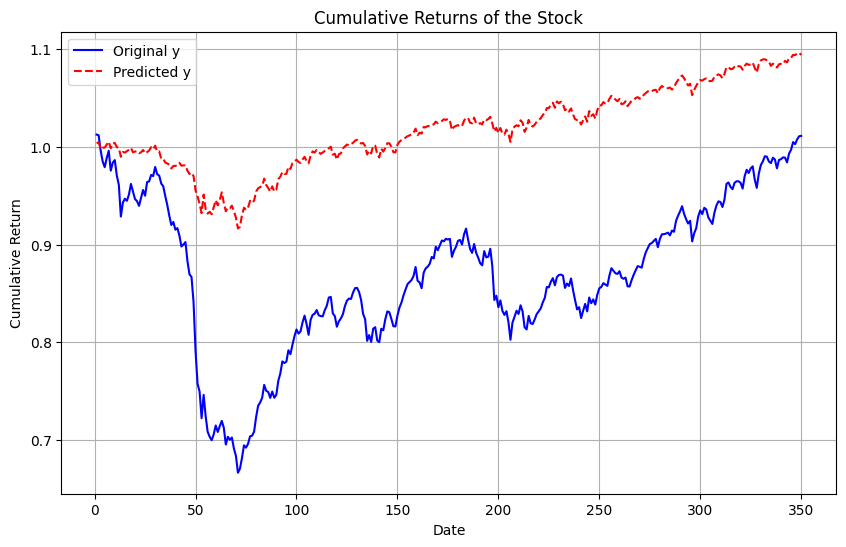

In [40]:
# Calculate cumulative returns
cumulative_y_ME = (1 + y_ret[:350]).cumprod()
cumulative_predicted_y = (1 + predicted_y).cumprod()

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(y_ME.index, cumulative_y_ME, label='Original y', color='blue')
plt.plot(y_ME.index, cumulative_predicted_y, label='Predicted y', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns of the Stock')
plt.legend()
plt.grid(True)
plt.show()

Good, our predicted y is above the real one. But seems to good to be true.

### Least Squares Regression (on values, NB check gaussianity)

In [ ]:
X_ME = X[:350]
y_ME = y[:350]

In [ ]:
# Fit OLS model
#X_with_const = sm.add_constant(X_ME)  # Add constant term
model = sm.OLS(y_ME, X_ME)
results = model.fit()

# Print summary of the model
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 Target   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.916e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):                        0.00
Time:                        20:35:05   Log-Likelihood:                         -1267.4
No. Observations:                 350   AIC:                                      2557.
Df Residuals:                     339   BIC:                                      2599.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

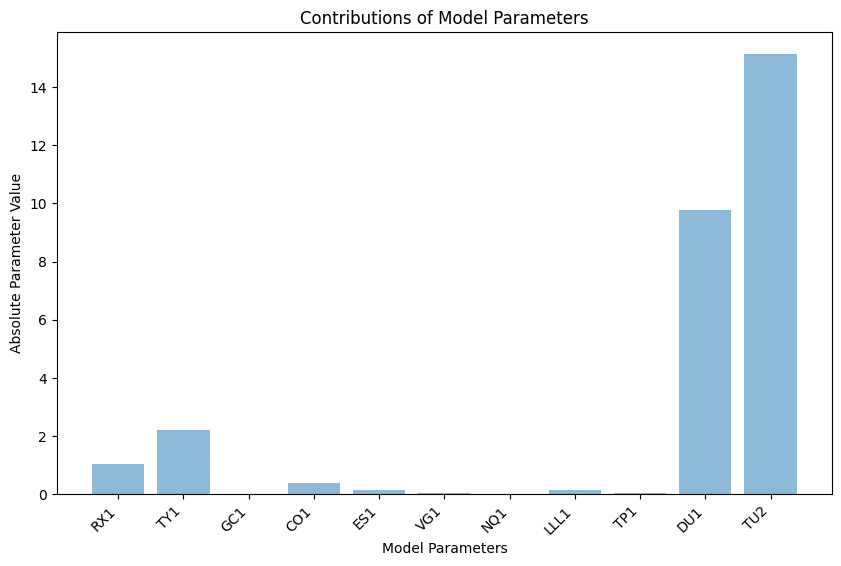

In [ ]:
# Get model parameters
parameters = results.params

# Plot contributions
plt.figure(figsize=(10, 6))
plt.bar(parameters.index, abs(parameters), alpha=0.5)

plt.xlabel('Model Parameters')
plt.ylabel('Absolute Parameter Value')
plt.title('Contributions of Model Parameters')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

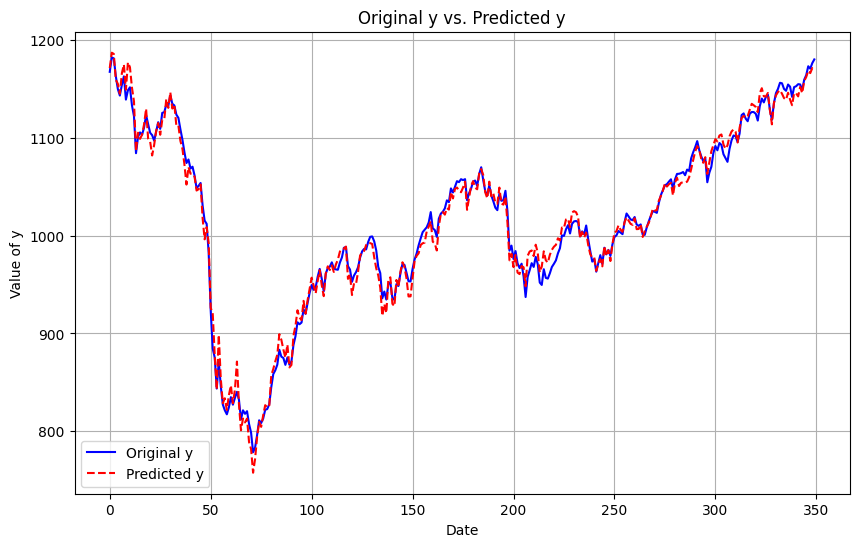

In [ ]:
# Get the predicted y values
predicted_y = results.predict(X_ME)

# Plot original y and predicted y
plt.figure(figsize=(10, 6))
plt.plot(y_ME.index, y_ME, label='Original y', color='blue')
plt.plot(y_ME.index, predicted_y, label='Predicted y', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value of y')
plt.title('Original y vs. Predicted y')
plt.legend()
plt.grid(True)
plt.show()


Worse result, we are replicating too well.

### Lasso Regression (on returns)

In [41]:
X_ME = X_ret[:350]
y_ME = y_ret[:350]

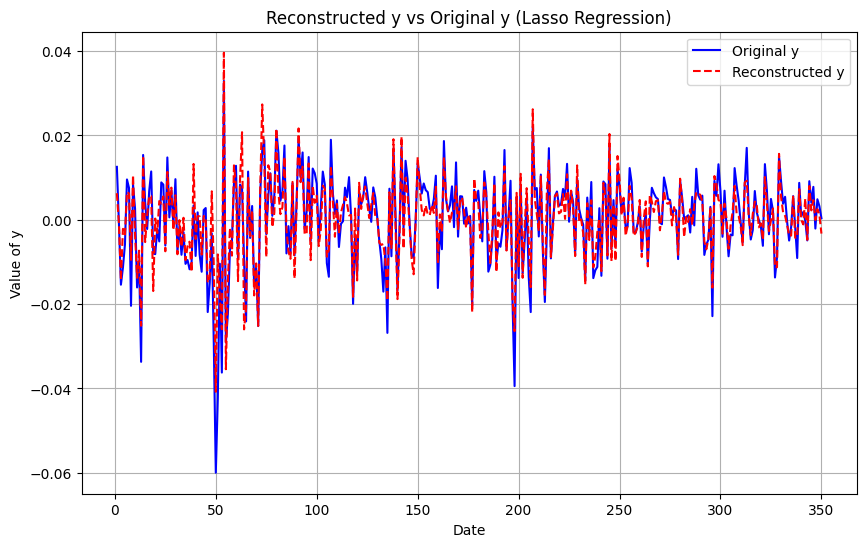

In [42]:
# Create Lasso regression model
lasso_model = Lasso(alpha=0.00001)  # You can adjust the alpha (regularization parameter) as needed

# Fit the model
lasso_model.fit(X_ME, y_ME)

# Predict on the entire dataset
y_pred = lasso_model.predict(X_ME)

# Plot the reconstructed version vs original y
plt.figure(figsize=(10, 6))
plt.plot(y_ME.index, y_ME, label='Original y', color='blue')
plt.plot(y_ME.index, y_pred, label='Reconstructed y', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value of y')
plt.title('Reconstructed y vs Original y (Lasso Regression)')
plt.legend()
plt.grid(True)
plt.show()

The chosen alpha is too big, we need to optimize it with CV

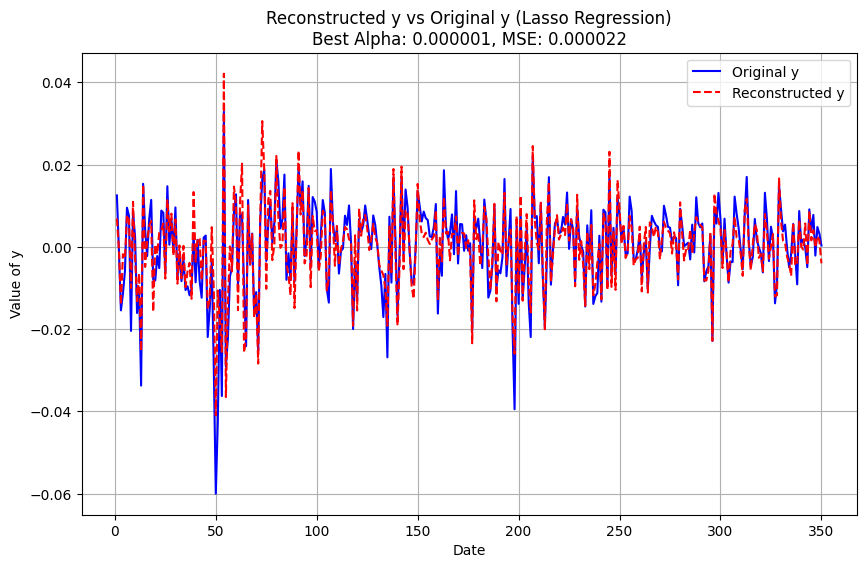

In [43]:
# Define a range of alpha values to search
alphas = np.logspace(-6, -2, 100)

# Create Lasso regression model
lasso_model = Lasso()

# Set up grid search
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(X_ME, y_ME)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']

# Create Lasso regression model with the best alpha
lasso_model = Lasso(alpha=best_alpha)

# Perform cross-validation predictions
y_pred_cv = cross_val_predict(lasso_model, X_ME, y_ME, cv=5)

# Calculate Mean Squared Error (MSE)
mse_cv = mean_squared_error(y_ME, y_pred_cv)

# Plot the reconstructed version vs original y
plt.figure(figsize=(10, 6))
plt.plot(y_ME.index, y_ME, label='Original y', color='blue')
plt.plot(y_ME.index, y_pred_cv, label='Reconstructed y', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value of y')
plt.title('Reconstructed y vs Original y (Lasso Regression)\nBest Alpha: {:.6f}, MSE: {:.6f}'.format(best_alpha, mse_cv))
plt.legend()
plt.grid(True)
plt.show()


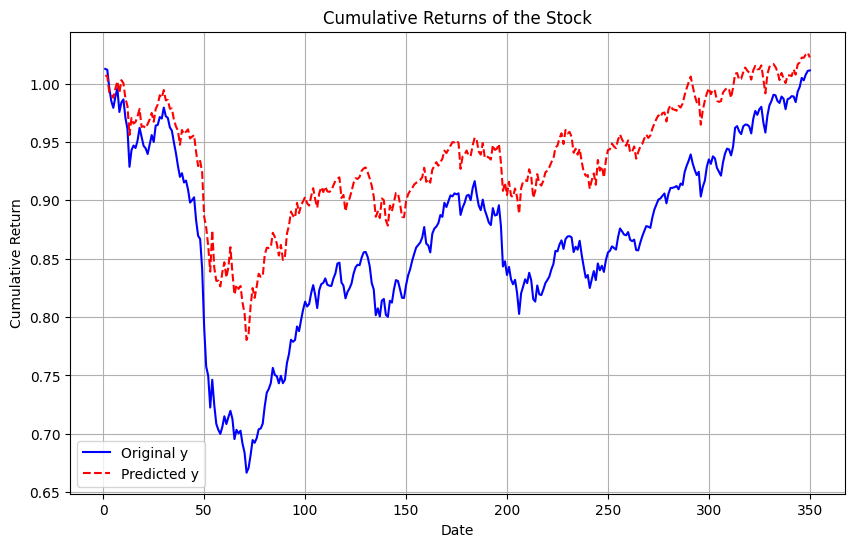

In [44]:
# Calculate cumulative returns
cumulative_y_ME = (1 + y_ME).cumprod()
cumulative_predicted_y = (1 + y_pred_cv).cumprod()

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(y_ME.index, cumulative_y_ME, label='Original y', color='blue')
plt.plot(y_ME.index, cumulative_predicted_y, label='Predicted y', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns of the Stock')
plt.legend()
plt.grid(True)
plt.show()

Better result, we are above real curve.

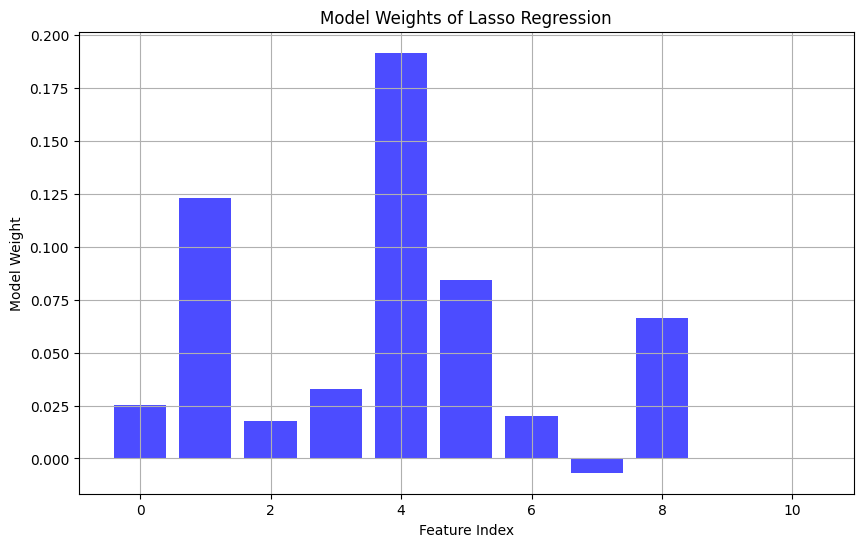

In [45]:
# Get the best estimator from grid search
best_lasso_model = grid_search.best_estimator_

# Get the coefficients of the best Lasso model
coefficients = best_lasso_model.coef_

# Plot the model weights
plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), coefficients, color='blue', alpha=0.7)
plt.xlabel('Feature Index')
plt.ylabel('Model Weight')
plt.title('Model Weights of Lasso Regression')
plt.grid(True)
plt.show()

### Lasso Regression (on values)

In [ ]:
X_ME = X[:350]
y_ME = y[:350]

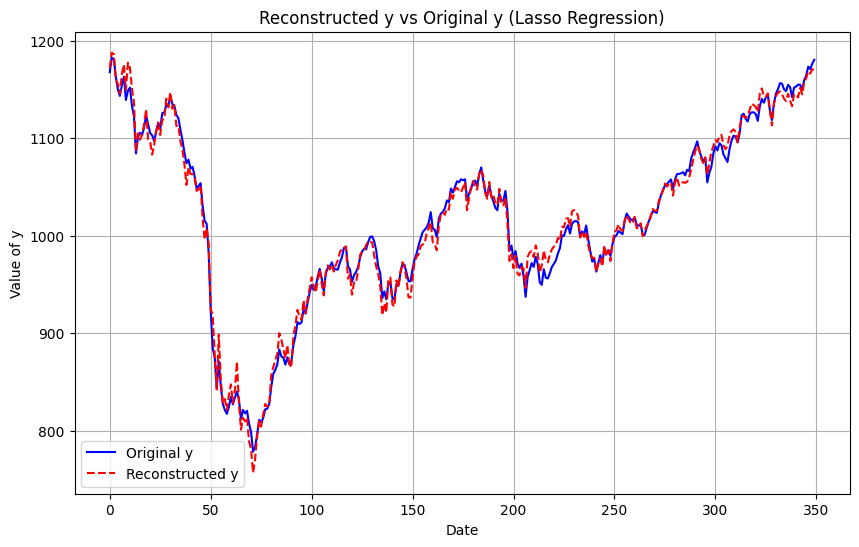

In [ ]:
# Create Lasso regression model
lasso_model = Lasso(alpha=0.1)  # You can adjust the alpha (regularization parameter) as needed

# Fit the model
lasso_model.fit(X_ME, y_ME)

# Predict on the entire dataset
y_pred = lasso_model.predict(X_ME)

# Plot the reconstructed version vs original y
plt.figure(figsize=(10, 6))
plt.plot(y_ME.index, y_ME, label='Original y', color='blue')
plt.plot(y_ME.index, y_pred, label='Reconstructed y', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value of y')
plt.title('Reconstructed y vs Original y (Lasso Regression)')
plt.legend()
plt.grid(True)
plt.show()

Bad result, replicating too well.

The chosen alpha is too big, we need to optimize it with CV

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.285e+03, tolerance: 1.813e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.204e+03, tolerance: 1.946e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.310e+03, tolerance: 2.870e

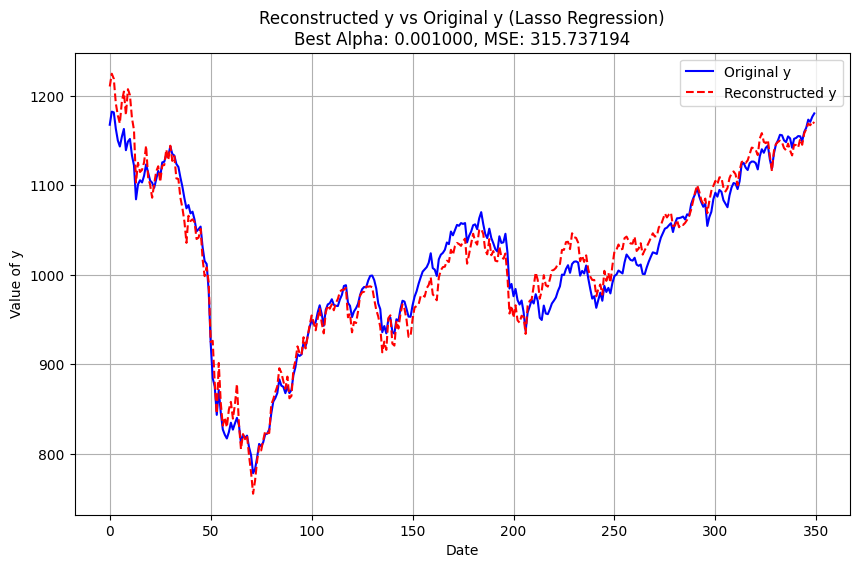

In [ ]:
# Define a range of alpha values to search
alphas = np.logspace(-3, 2, 100)

# Create Lasso regression model
lasso_model = Lasso()

# Set up grid search
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(X_ME, y_ME)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']

# Create Lasso regression model with the best alpha
lasso_model = Lasso(alpha=best_alpha)

# Perform cross-validation predictions
y_pred_cv = cross_val_predict(lasso_model, X_ME, y_ME, cv=5)

# Calculate Mean Squared Error (MSE)
mse_cv = mean_squared_error(y_ME, y_pred_cv)

# Plot the reconstructed version vs original y
plt.figure(figsize=(10, 6))
plt.plot(y_ME.index, y_ME, label='Original y', color='blue')
plt.plot(y_ME.index, y_pred_cv, label='Reconstructed y', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value of y')
plt.title('Reconstructed y vs Original y (Lasso Regression)\nBest Alpha: {:.6f}, MSE: {:.6f}'.format(best_alpha, mse_cv))
plt.legend()
plt.grid(True)
plt.show()


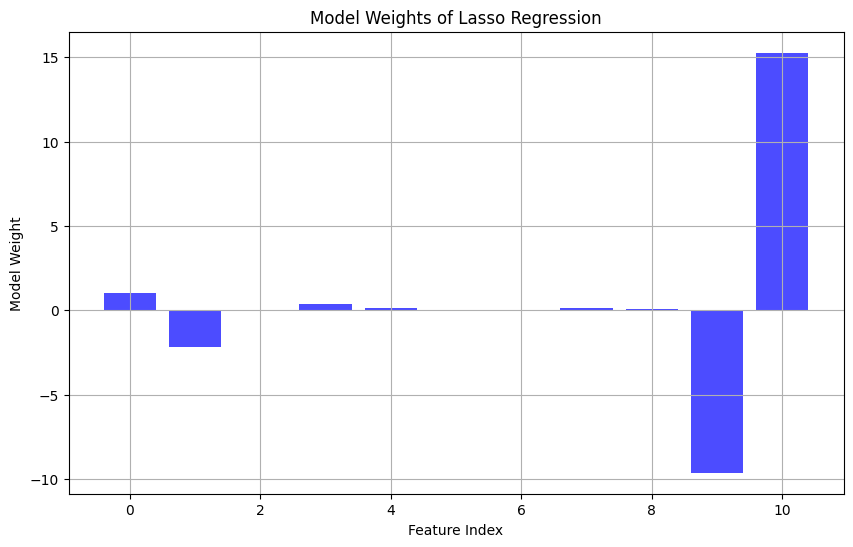

In [ ]:
# Get the best estimator from grid search
best_lasso_model = grid_search.best_estimator_

# Get the coefficients of the best Lasso model
coefficients = best_lasso_model.coef_

# Plot the model weights
plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), coefficients, color='blue', alpha=0.7)
plt.xlabel('Feature Index')
plt.ylabel('Model Weight')
plt.title('Model Weights of Lasso Regression')
plt.grid(True)
plt.show()

### Ridge Regression (on returns)

In [46]:
X_ME = X_ret[:350]
y_ME = y_ret[:350]

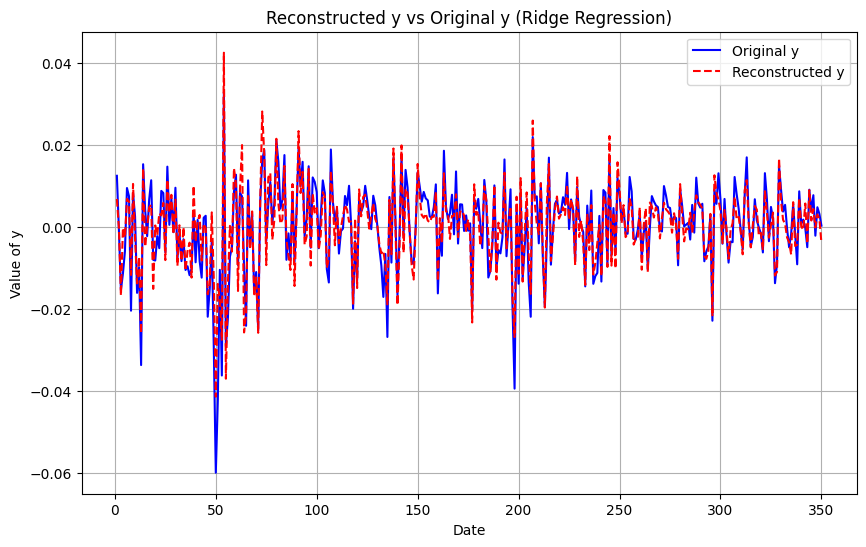

In [47]:
# Create Ridge regression model
ridge_model = Ridge(alpha=0.01)  # You can adjust the alpha (regularization parameter) as needed

# Fit the model
ridge_model.fit(X_ME, y_ME)

# Predict on the entire dataset
y_pred = ridge_model.predict(X_ME)

# Plot the reconstructed version vs original y
plt.figure(figsize=(10, 6))
plt.plot(y_ME.index, y_ME, label='Original y', color='blue')
plt.plot(y_ME.index, y_pred, label='Reconstructed y', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value of y')
plt.title('Reconstructed y vs Original y (Ridge Regression)')
plt.legend()
plt.grid(True)
plt.show()


The chosen alpha is too big, we need to optimize it with CV

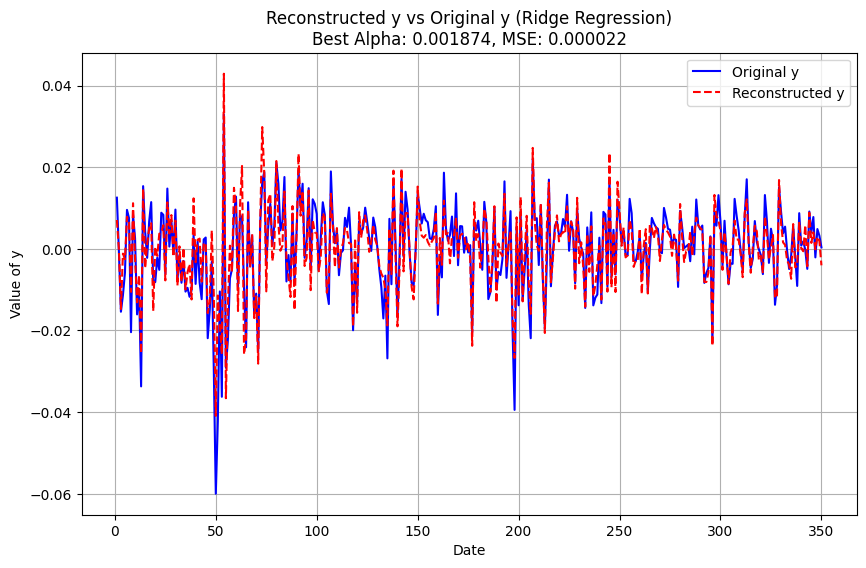

In [48]:
# Define a range of alpha values to search
alphas = np.logspace(-6, -2, 100)

# Create Ridge regression model
ridge_model = Ridge()

# Set up grid search
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(X_ME, y_ME)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']

# Create Ridge regression model with the best alpha
ridge_model = Ridge(alpha=best_alpha)

# Perform cross-validation predictions
y_pred_cv = cross_val_predict(ridge_model, X_ME, y_ME, cv=5)

# Calculate Mean Squared Error (MSE)
mse_cv = mean_squared_error(y_ME, y_pred_cv)

# Plot the reconstructed version vs original y
plt.figure(figsize=(10, 6))
plt.plot(y_ME.index, y_ME, label='Original y', color='blue')
plt.plot(y_ME.index, y_pred_cv, label='Reconstructed y', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value of y')
plt.title('Reconstructed y vs Original y (Ridge Regression)\nBest Alpha: {:.6f}, MSE: {:.6f}'.format(best_alpha, mse_cv))
plt.legend()
plt.grid(True)
plt.show()


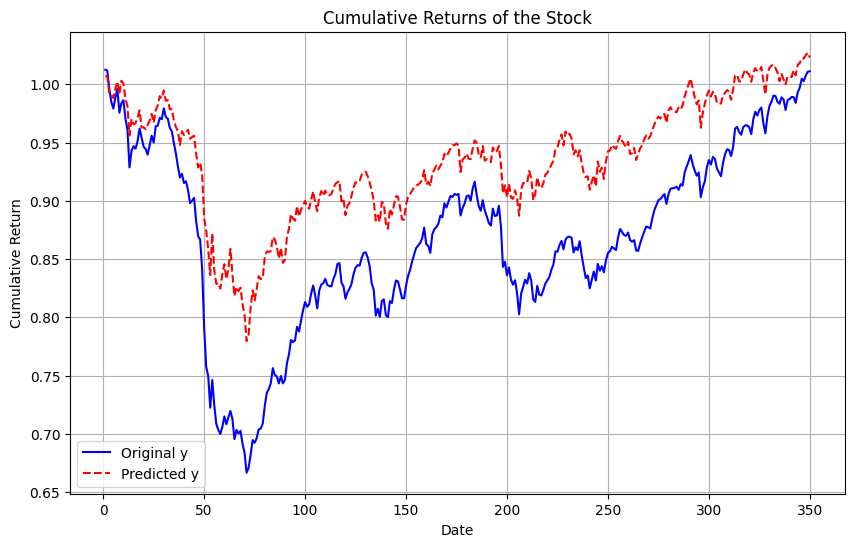

In [49]:
# Calculate cumulative returns
cumulative_y_ME = (1 + y_ME).cumprod()
cumulative_predicted_y = (1 + y_pred_cv).cumprod()

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(y_ME.index, cumulative_y_ME, label='Original y', color='blue')
plt.plot(y_ME.index, cumulative_predicted_y, label='Predicted y', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns of the Stock')
plt.legend()
plt.grid(True)
plt.show()


Good, we are above.

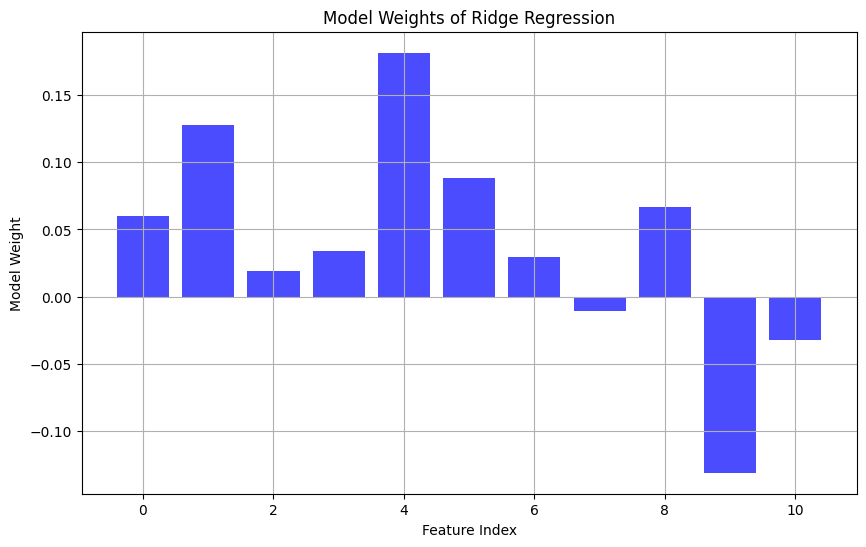

In [50]:
# Get the best estimator from grid search
best_ridge_model = grid_search.best_estimator_

# Get the coefficients of the best Ridge model
coefficients = best_ridge_model.coef_

# Plot the model weights
plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), coefficients, color='blue', alpha=0.7)
plt.xlabel('Feature Index')
plt.ylabel('Model Weight')
plt.title('Model Weights of Ridge Regression')
plt.grid(True)
plt.show()

### Ridge Regression (on values)

In [ ]:
X_ME = X[:350]
y_ME = y[:350]

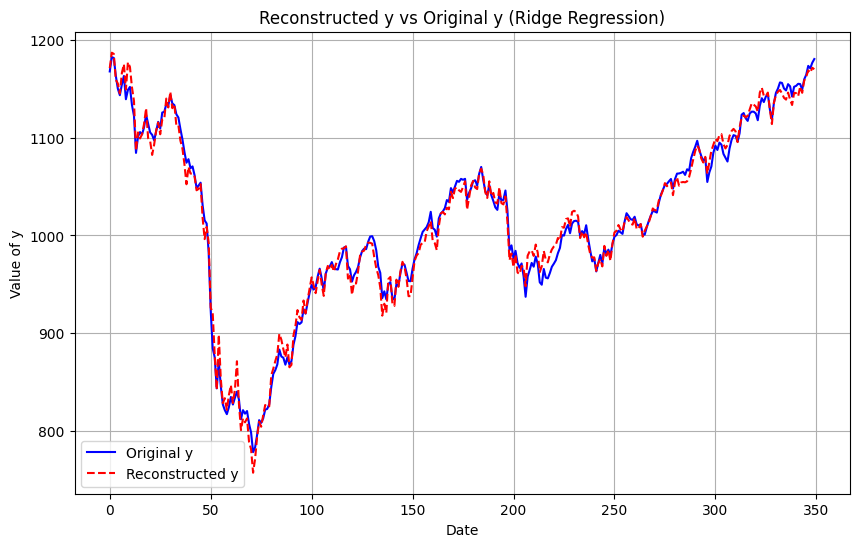

In [ ]:
# Create Ridge regression model
ridge_model = Ridge(alpha=0.1)  # You can adjust the alpha (regularization parameter) as needed

# Fit the model
ridge_model.fit(X_ME, y_ME)

# Predict on the entire dataset
y_pred = ridge_model.predict(X_ME)

# Plot the reconstructed version vs original y
plt.figure(figsize=(10, 6))
plt.plot(y_ME.index, y_ME, label='Original y', color='blue')
plt.plot(y_ME.index, y_pred, label='Reconstructed y', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value of y')
plt.title('Reconstructed y vs Original y (Ridge Regression)')
plt.legend()
plt.grid(True)
plt.show()


Bad, we replicate too well.

The chosen alpha is too big, we need to optimize it with CV

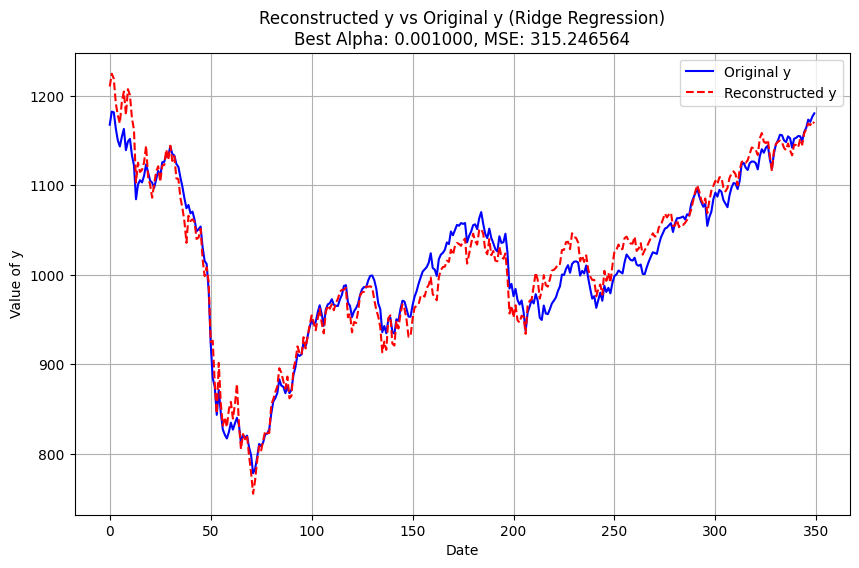

In [ ]:
# Define a range of alpha values to search
alphas = np.logspace(-3, 2, 100)

# Create Ridge regression model
ridge_model = Ridge()

# Set up grid search
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(X_ME, y_ME)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']

# Create Ridge regression model with the best alpha
ridge_model = Ridge(alpha=best_alpha)

# Perform cross-validation predictions
y_pred_cv = cross_val_predict(ridge_model, X_ME, y_ME, cv=5)

# Calculate Mean Squared Error (MSE)
mse_cv = mean_squared_error(y_ME, y_pred_cv)

# Plot the reconstructed version vs original y
plt.figure(figsize=(10, 6))
plt.plot(y_ME.index, y_ME, label='Original y', color='blue')
plt.plot(y_ME.index, y_pred_cv, label='Reconstructed y', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value of y')
plt.title('Reconstructed y vs Original y (Ridge Regression)\nBest Alpha: {:.6f}, MSE: {:.6f}'.format(best_alpha, mse_cv))
plt.legend()
plt.grid(True)
plt.show()

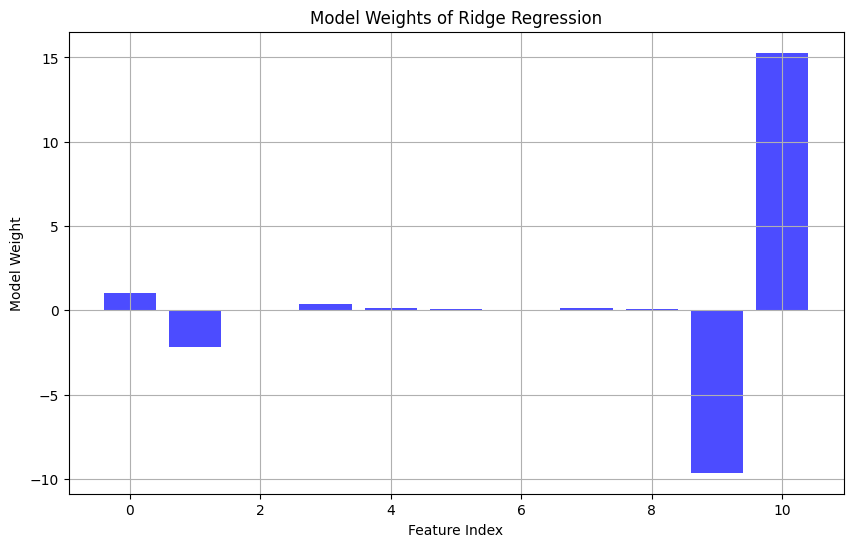

In [ ]:
# Get the best estimator from grid search
best_ridge_model = grid_search.best_estimator_

# Get the coefficients of the best Ridge model
coefficients = best_ridge_model.coef_

# Plot the model weights
plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), coefficients, color='blue', alpha=0.7)
plt.xlabel('Feature Index')
plt.ylabel('Model Weight')
plt.title('Model Weights of Ridge Regression')
plt.grid(True)
plt.show()

### Elastic Net Regression (on returns)

In [ ]:
# Create a new DataFrame X with columns from df.columns[5:]
X = df[df.columns[5:]].copy()

# Apply pct_change and dropna to each column
for col in X.columns:
    X[col] = X[col].pct_change().dropna()

X = X.dropna()

# Display the resulting DataFrame
print(X.head())

        RX1       TY1       GC1       CO1       ES1       VG1       NQ1  \
1  0.000792  0.001272  0.037945  0.055401  0.006883  0.018894  0.002599   
2  0.000000  0.001977  0.045189  0.066560 -0.007161 -0.011394  0.007102   
3  0.004921  0.007610 -0.029633 -0.047502 -0.027377 -0.023051 -0.074659   
4  0.003236  0.012867 -0.009512  0.074975 -0.025114 -0.006246 -0.015120   
5  0.003138  0.007042  0.028557 -0.031103 -0.013485 -0.012803 -0.001474   

       LLL1       TP1       DU1       TU2    Target  
1  0.028671  0.025470  0.000242  0.000904  0.012541  
2 -0.002946 -0.021732  0.000000  0.002258 -0.000703  
3 -0.037121 -0.085687  0.001789  0.002478 -0.015407  
4 -0.036035  0.022215  0.001979  0.006142 -0.011335  
5 -0.023670  0.008489  0.001204  0.001489 -0.005836  


In [ ]:
X_ME = X[:350]
y_ME = y_ret[:350]

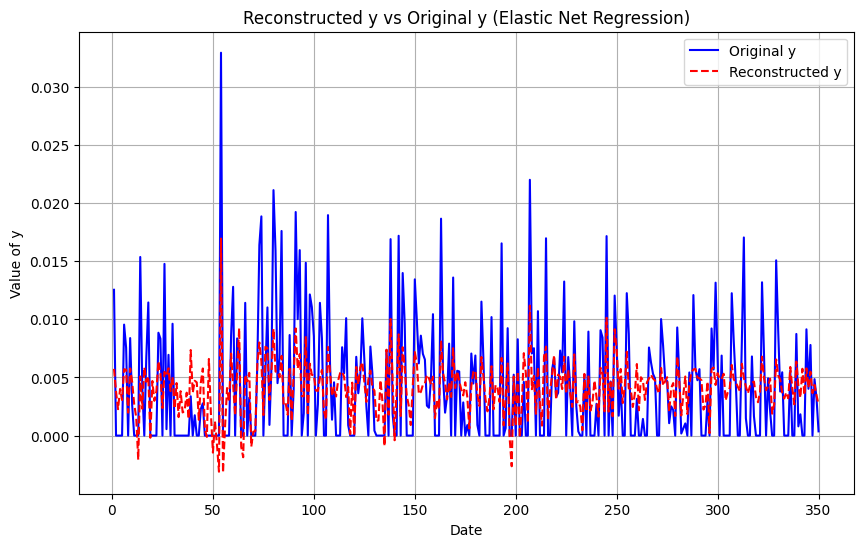

In [ ]:
# Create Elastic Net regression model
elastic_net_model = ElasticNet(alpha=0.0001, l1_ratio=0.5)  # You can adjust alpha and l1_ratio as needed

# Fit the model
elastic_net_model.fit(X_ME, y_ME)

# Predict on the entire dataset
y_pred = elastic_net_model.predict(X_ME)
plt.figure(figsize=(10, 6))
plt.plot(y_ME.index, y_ME, label='Original y', color='blue')
plt.plot(y_ME.index, y_pred, label='Reconstructed y', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value of y')
plt.title('Reconstructed y vs Original y (Elastic Net Regression)')
plt.legend()
plt.grid(True)
plt.show()

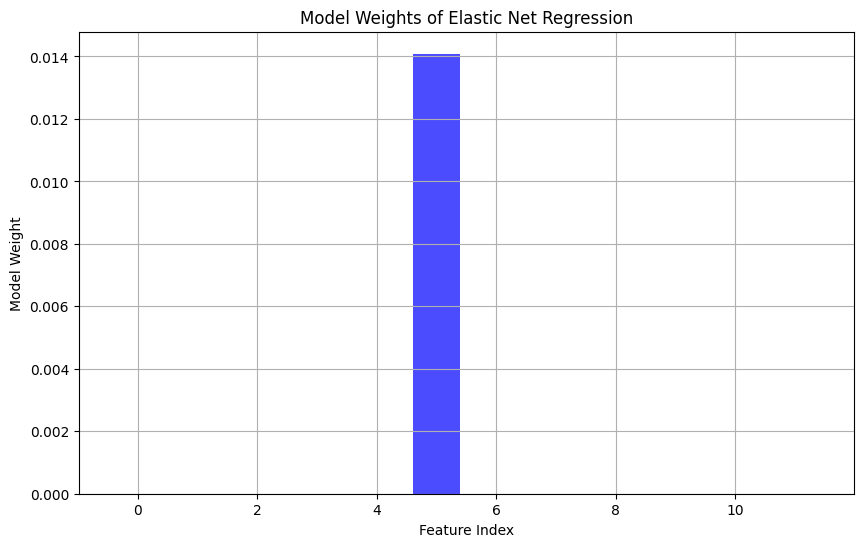

In [ ]:
# Create Elastic Net regression model
elastic_net_model = ElasticNet()

# Set up grid search
param_grid = {'alpha': alphas, 'l1_ratio': [0.1, 0.5, 0.7, 0.9]}  # Adjust l1_ratio values as needed
grid_search = GridSearchCV(estimator=elastic_net_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(X_ME, y_ME)

# Get the best Elastic Net model
best_elastic_net_model = grid_search.best_estimator_

# Get the coefficients of the best Elastic Net model
coefficients = best_elastic_net_model.coef_

# Plot the model weights
plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), coefficients, color='blue', alpha=0.7)
plt.xlabel('Feature Index')
plt.ylabel('Model Weight')
plt.title('Model Weights of Elastic Net Regression')
plt.grid(True)
plt.show()

### Elastic Regression (on values)

In [ ]:
# Create a new DataFrame X with columns from df.columns[5:]
X = df[df.columns[5:]].copy()

# Display the resulting DataFrame
print(X.head())

      RX1         TY1    GC1    CO1      ES1     VG1      NQ1    LLL1     TP1  \
0  113.70  110.515625  759.0  82.85  1525.50  4393.0  2212.00  1287.0  1570.5   
1  113.79  110.656250  787.8  87.44  1536.00  4476.0  2217.75  1323.9  1610.5   
2  113.79  110.875000  823.4  93.26  1525.00  4425.0  2233.50  1320.0  1575.5   
3  114.35  111.718750  799.0  88.83  1483.25  4323.0  2066.75  1271.0  1440.5   
4  114.72  113.156250  791.4  95.49  1446.00  4296.0  2035.50  1225.2  1472.5   

       DU1         TU2       Target  
0  103.385  103.718750  1167.728450  
1  103.410  103.812500  1182.372825  
2  103.410  104.046875  1181.541450  
3  103.595  104.304688  1163.337925  
4  103.800  104.945312  1150.151150  


In [ ]:
X_ME = X[:350]
y_ME = y_ret[:350]

In [ ]:
# Create Elastic Net regression model
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)  # You can adjust alpha and l1_ratio as needed

# Fit the model
elastic_net_model.fit(X_ME, y_ME)

# Predict on the entire dataset
y_pred = elastic_net_model.predict(X_ME)

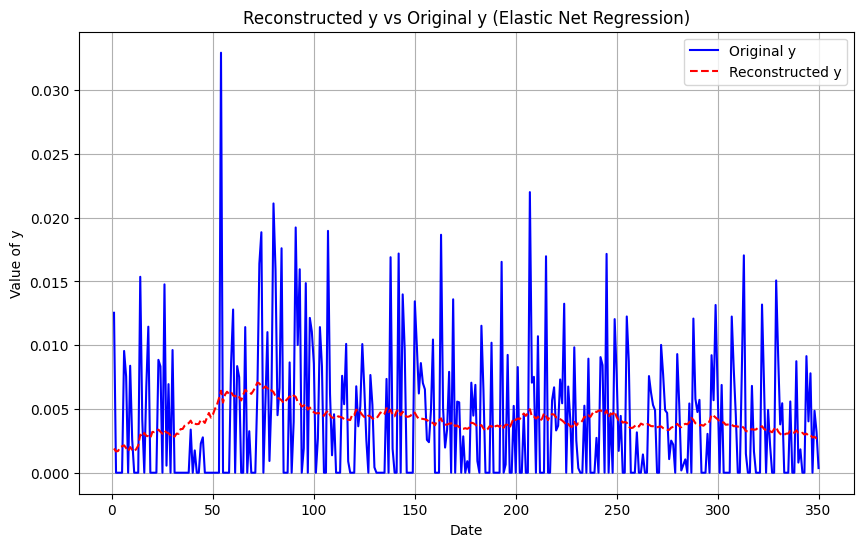

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_ME.index, y_ME, label='Original y', color='blue')
plt.plot(y_ME.index, y_pred, label='Reconstructed y', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value of y')
plt.title('Reconstructed y vs Original y (Elastic Net Regression)')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.069e-06, tolerance: 7.541e-07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.732e-06, tolerance: 8.458e-07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.229e-06, tolerance: 7.541e

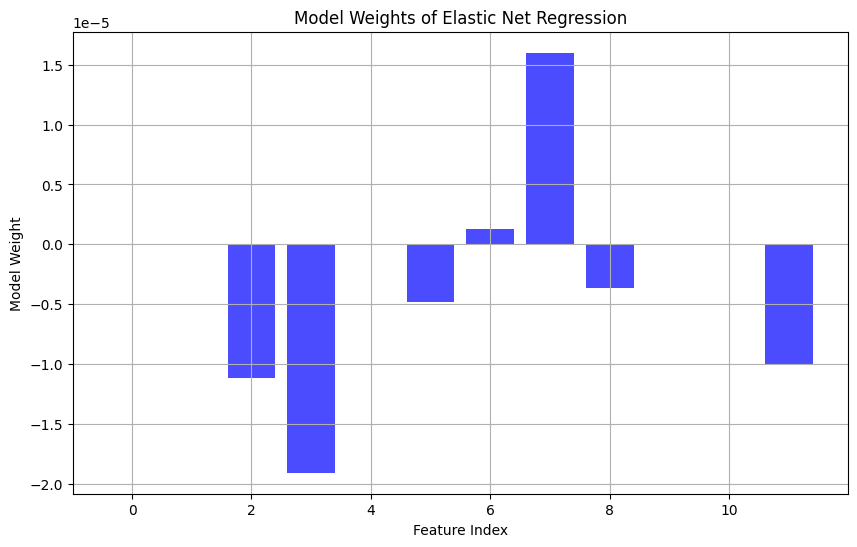

In [ ]:
# Create Elastic Net regression model
elastic_net_model = ElasticNet()

# Set up grid search
param_grid = {'alpha': alphas, 'l1_ratio': [0.1, 0.5, 0.7, 0.9]}  # Adjust l1_ratio values as needed
grid_search = GridSearchCV(estimator=elastic_net_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(X_ME, y_ME)

# Get the best Elastic Net model
best_elastic_net_model = grid_search.best_estimator_

# Get the coefficients of the best Elastic Net model
coefficients = best_elastic_net_model.coef_

# Plot the model weights
plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), coefficients, color='blue', alpha=0.7)
plt.xlabel('Feature Index')
plt.ylabel('Model Weight')
plt.title('Model Weights of Elastic Net Regression')
plt.grid(True)
plt.show()

## Backtesting the models

In [51]:
# Create a new DataFrame X with columns from df.columns[5:]
X = df[df.columns[5:]].copy()

# Apply pct_change and dropna to each column
for col in X.columns:
    X[col] = X[col].pct_change().dropna()

X = X.dropna()

y = y_ret

# Display the resulting DataFrame
print(X.head())

        RX1       TY1       GC1       CO1       ES1       VG1       NQ1  \
1  0.000792  0.001272  0.037945  0.055401  0.006883  0.018894  0.002599   
2  0.000000  0.001977  0.045189  0.066560 -0.007161 -0.011394  0.007102   
3  0.004921  0.007610 -0.029633 -0.047502 -0.027377 -0.023051 -0.074659   
4  0.003236  0.012867 -0.009512  0.074975 -0.025114 -0.006246 -0.015120   
5  0.003138  0.007042  0.028557 -0.031103 -0.013485 -0.012803 -0.001474   

       LLL1       TP1       DU1       TU2    Target  
1  0.028671  0.025470  0.000242  0.000904  0.012541  
2 -0.002946 -0.021732  0.000000  0.002258 -0.000703  
3 -0.037121 -0.085687  0.001789  0.002478 -0.015407  
4 -0.036035  0.022215  0.001979  0.006142 -0.011335  
5 -0.023670  0.008489  0.001204  0.001489 -0.005836  


rolling window [T, T+k] vs keep window. make keep window [0,T] is more data always better than less data?
use XGBoost, lightGBM regressor.

In [55]:
def price2ret(prices):
    return prices.pct_change().dropna()

def ret2price(returns):
    return (1 + returns).cumprod()

### OLS Backtesting (rolling window)

In [60]:
rolling_window = 156
i = 1
endsample = 0
gross_exposures = []
r_enet2 = []

while endsample < X.shape[0] - 2:
  startsample = i
  endsample = i + rolling_window - 1
  model = sm.OLS(y[startsample:endsample], X[startsample:endsample])
  results = model.fit()
  b = results.params
  gross_exposures += [np.sum(np.abs(b))]
  r = np.dot(np.array(X.iloc[endsample + 1]),b)
  r_enet2 += [r]
  i = i + 1

r_enet2 = np.array(r_enet2)

In [61]:
TE = r_enet2 - y[rolling_window + 1:]
TEV = np.std(TE)*np.sqrt(52)
print(f'TEV = {TEV}')


from typing_extensions import TypeVarTuple
log_r_clone = np.diff(np.log(ret2price(r_enet2)))
log_r_target = np.diff(np.log(ret2price(y[rolling_window + 1:])))
log_TE = log_r_clone - log_r_target
mean_TR_target = np.exp(np.mean(log_r_target)*52) - 1

mean_TR_clone = np.exp(np.mean(log_r_clone)*52) - 1
mean_ER = np.exp(np.mean(log_TE)*52) - 1

IR = mean_ER/TEV

print(f'mean TR target = {mean_TR_target}')
print(f'mean TR clone = {mean_TR_clone}')
print(f'mean ER = {mean_ER}')
print(f'IR = {IR}')

TEV = 8.708343097766598e-17
mean TR target = 0.043119585666434146
mean TR clone = 0.043119585666433924
mean ER = 0.0
IR = 0.0


### OLS Backtesting (fixed window)

In [67]:
rolling_window = 156
i = 1
endsample = 0
gross_exposures = []
r_enet2 = []

while endsample < X.shape[0] - 2:
  startsample = i
  endsample = i + rolling_window - 1
  model = sm.OLS(y[:endsample], X[:endsample])
  results = model.fit()
  b = results.params
  gross_exposures += [np.sum(np.abs(b))]
  r = np.dot(np.array(X.iloc[endsample + 1]),b)
  r_enet2 += [r]
  i = i + 1

r_enet2 = np.array(r_enet2)

In [68]:
TE = r_enet2 - y[rolling_window + 1:]
TEV = np.std(TE)*np.sqrt(52)
print(f'TEV = {TEV}')


from typing_extensions import TypeVarTuple
log_r_clone = np.diff(np.log(ret2price(r_enet2)))
log_r_target = np.diff(np.log(ret2price(y[rolling_window + 1:])))
log_TE = log_r_clone - log_r_target
mean_TR_target = np.exp(np.mean(log_r_target)*52) - 1

mean_TR_clone = np.exp(np.mean(log_r_clone)*52) - 1
mean_ER = np.exp(np.mean(log_TE)*52) - 1

IR = mean_ER/TEV

print(f'mean TR target = {mean_TR_target}')
print(f'mean TR clone = {mean_TR_clone}')
print(f'mean ER = {mean_ER}')
print(f'IR = {IR}')

TEV = 6.393995229856214e-17
mean TR target = 0.043119585666434146
mean TR clone = 0.043119585666434146
mean ER = 0.0
IR = 0.0


### positive OLS Backtesting (rolling window)

In [79]:
rolling_window = 156
i = 1
endsample = 0
gross_exposures = []
r_enet2 = []

y_pos = y
y_pos[y_pos < 0] = 0

while endsample < X.shape[0] - 2:
  startsample = i
  endsample = i + rolling_window - 1
  model = sm.OLS(y_pos[startsample:endsample], X[startsample:endsample])
  results = model.fit()
  b = results.params
  gross_exposures += [np.sum(np.abs(b))]
  r = np.dot(np.array(X.iloc[endsample + 1]),b)
  r_enet2 += [r]
  i = i + 1

r_enet2 = np.array(r_enet2)

In [80]:
TE = r_enet2 - y[rolling_window + 1:]
TEV = np.std(TE)*np.sqrt(52)
print(f'TEV = {TEV}')


from typing_extensions import TypeVarTuple
log_r_clone = np.diff(np.log(ret2price(r_enet2)))
log_r_target = np.diff(np.log(ret2price(y[rolling_window + 1:])))
log_TE = log_r_clone - log_r_target
mean_TR_target = np.exp(np.mean(log_r_target)*52) - 1

mean_TR_clone = np.exp(np.mean(log_r_clone)*52) - 1
mean_ER = np.exp(np.mean(log_TE)*52) - 1

IR = mean_ER/TEV

print(f'mean TR target = {mean_TR_target}')
print(f'mean TR clone = {mean_TR_clone}')
print(f'mean ER = {mean_ER}')
print(f'IR = {IR}')

TEV = 0.027651501251118024
mean TR target = 0.2276120910320112
mean TR clone = 0.020435493243808445
mean ER = -0.16876389480168486
IR = -6.103245291062136


### positive OLS Backtesting (fixed window)

In [81]:
rolling_window = 156
i = 1
endsample = 0
gross_exposures = []
r_enet2 = []

y_pos = y
y_pos[y_pos < 0] = 0

while endsample < X.shape[0] - 2:
  startsample = i
  endsample = i + rolling_window - 1
  model = sm.OLS(y[:endsample], X[:endsample])
  results = model.fit()
  b = results.params
  gross_exposures += [np.sum(np.abs(b))]
  r = np.dot(np.array(X.iloc[endsample + 1]),b)
  r_enet2 += [r]
  i = i + 1

r_enet2 = np.array(r_enet2)

In [82]:
TE = r_enet2 - y[rolling_window + 1:]
TEV = np.std(TE)*np.sqrt(52)
print(f'TEV = {TEV}')


from typing_extensions import TypeVarTuple
log_r_clone = np.diff(np.log(ret2price(r_enet2)))
log_r_target = np.diff(np.log(ret2price(y[rolling_window + 1:])))
log_TE = log_r_clone - log_r_target
mean_TR_target = np.exp(np.mean(log_r_target)*52) - 1

mean_TR_clone = np.exp(np.mean(log_r_clone)*52) - 1
mean_ER = np.exp(np.mean(log_TE)*52) - 1

IR = mean_ER/TEV

print(f'mean TR target = {mean_TR_target}')
print(f'mean TR clone = {mean_TR_clone}')
print(f'mean ER = {mean_ER}')
print(f'IR = {IR}')

TEV = 0.024754863194794408
mean TR target = 0.2276120910320112
mean TR clone = 0.017346649927869162
mean ER = -0.17128003433672534
IR = -6.919045885607765


### Lasso Backtesting (rolling window)

In [62]:
rolling_window = 156
i = 1
endsample = 0
gross_exposures = []
r_enet2 = []

while endsample < X.shape[0] - 2:
  startsample = i
  endsample = i + rolling_window - 1
  lasso_model = Lasso(alpha=0.000007)
  lasso_model.fit(X[startsample:endsample], y[startsample:endsample])
  b = lasso_model.coef_
  gross_exposures += [np.sum(np.abs(b))]
  r = np.dot(np.array(X.iloc[endsample + 1]),b)
  r_enet2 += [r]
  i = i + 1

r_enet2 = np.array(r_enet2)

In [63]:
TE = r_enet2 - y[rolling_window + 1:]
TEV = np.std(TE)*np.sqrt(52)
print(f'TEV = {TEV}')


from typing_extensions import TypeVarTuple
log_r_clone = np.diff(np.log(ret2price(r_enet2)))
log_r_target = np.diff(np.log(ret2price(y[rolling_window + 1:])))
log_TE = log_r_clone - log_r_target
mean_TR_target = np.exp(np.mean(log_r_target)*52) - 1

mean_TR_clone = np.exp(np.mean(log_r_clone)*52) - 1
mean_ER = np.exp(np.mean(log_TE)*52) - 1

IR = mean_ER/TEV

print(f'mean TR target = {mean_TR_target}')
print(f'mean TR clone = {mean_TR_clone}')
print(f'mean ER = {mean_ER}')
print(f'IR = {IR}')

TEV = 0.011964374004684867
mean TR target = 0.043119585666434146
mean TR clone = 0.044834700851945186
mean ER = 0.001644217220229116
IR = 0.13742609680918477


### Lasso Backtesting (fixed window)



In [69]:
rolling_window = 156
i = 1
endsample = 0
gross_exposures = []
r_enet2 = []

while endsample < X.shape[0] - 2:
  startsample = i
  endsample = i + rolling_window - 1
  lasso_model = Lasso(alpha=0.000007)
  lasso_model.fit(X[:endsample], y[:endsample])
  b = lasso_model.coef_
  gross_exposures += [np.sum(np.abs(b))]
  r = np.dot(np.array(X.iloc[endsample + 1]),b)
  r_enet2 += [r]
  i = i + 1

r_enet2 = np.array(r_enet2)

In [70]:
TE = r_enet2 - y[rolling_window + 1:]
TEV = np.std(TE)*np.sqrt(52)
print(f'TEV = {TEV}')


from typing_extensions import TypeVarTuple
log_r_clone = np.diff(np.log(ret2price(r_enet2)))
log_r_target = np.diff(np.log(ret2price(y[rolling_window + 1:])))
log_TE = log_r_clone - log_r_target
mean_TR_target = np.exp(np.mean(log_r_target)*52) - 1

mean_TR_clone = np.exp(np.mean(log_r_clone)*52) - 1
mean_ER = np.exp(np.mean(log_TE)*52) - 1

IR = mean_ER/TEV

print(f'mean TR target = {mean_TR_target}')
print(f'mean TR clone = {mean_TR_clone}')
print(f'mean ER = {mean_ER}')
print(f'IR = {IR}')

TEV = 0.007146392610832298
mean TR target = 0.043119585666434146
mean TR clone = 0.04093338201504504
mean ER = -0.0020958322338394675
IR = -0.2932713535305442


### Ridge Backtesting (rolling window)

In [65]:
rolling_window = 156
i = 1
endsample = 0
gross_exposures = []
r_enet2 = []

while endsample < X.shape[0] - 2:
  startsample = i
  endsample = i + rolling_window - 1
  ridge_model = Ridge(alpha=0.001874)
  ridge_model.fit(X[startsample:endsample], y[startsample:endsample])
  b = ridge_model.coef_
  gross_exposures += [np.sum(np.abs(b))]
  r = np.dot(np.array(X.iloc[endsample + 1]),b)
  r_enet2 += [r]
  i = i + 1

r_enet2 = np.array(r_enet2)

In [66]:
TE = r_enet2 - y[rolling_window + 1:]
TEV = np.std(TE)*np.sqrt(52)
print(f'TEV = {TEV}')


from typing_extensions import TypeVarTuple
log_r_clone = np.diff(np.log(ret2price(r_enet2)))
log_r_target = np.diff(np.log(ret2price(y[rolling_window + 1:])))
log_TE = log_r_clone - log_r_target
mean_TR_target = np.exp(np.mean(log_r_target)*52) - 1

mean_TR_clone = np.exp(np.mean(log_r_clone)*52) - 1
mean_ER = np.exp(np.mean(log_TE)*52) - 1

IR = mean_ER/TEV

print(f'mean TR target = {mean_TR_target}')
print(f'mean TR clone = {mean_TR_clone}')
print(f'mean ER = {mean_ER}')
print(f'IR = {IR}')

TEV = 0.01561639014905053
mean TR target = 0.043119585666434146
mean TR clone = 0.04746293706715554
mean ER = 0.004163809653661588
IR = 0.2666307394935792


### Ridge Backtesting (fixed window)

In [71]:
rolling_window = 156
i = 1
endsample = 0
gross_exposures = []
r_enet2 = []

while endsample < X.shape[0] - 2:
  startsample = i
  endsample = i + rolling_window - 1
  ridge_model = Ridge(alpha=0.001874)
  ridge_model.fit(X[:endsample], y[:endsample])
  b = ridge_model.coef_
  gross_exposures += [np.sum(np.abs(b))]
  r = np.dot(np.array(X.iloc[endsample + 1]),b)
  r_enet2 += [r]
  i = i + 1

r_enet2 = np.array(r_enet2)

In [72]:
TE = r_enet2 - y[rolling_window + 1:]
TEV = np.std(TE)*np.sqrt(52)
print(f'TEV = {TEV}')


from typing_extensions import TypeVarTuple
log_r_clone = np.diff(np.log(ret2price(r_enet2)))
log_r_target = np.diff(np.log(ret2price(y[rolling_window + 1:])))
log_TE = log_r_clone - log_r_target
mean_TR_target = np.exp(np.mean(log_r_target)*52) - 1

mean_TR_clone = np.exp(np.mean(log_r_clone)*52) - 1
mean_ER = np.exp(np.mean(log_TE)*52) - 1

IR = mean_ER/TEV

print(f'mean TR target = {mean_TR_target}')
print(f'mean TR clone = {mean_TR_clone}')
print(f'mean ER = {mean_ER}')
print(f'IR = {IR}')

TEV = 0.005512509882313724
mean TR target = 0.043119585666434146
mean TR clone = 0.044508431831599804
mean ER = 0.0013314352297186804
IR = 0.24152976740965898
